In [ ]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
train_data = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_data  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

SAMPLE AT INDEX 0
LABEL: 5


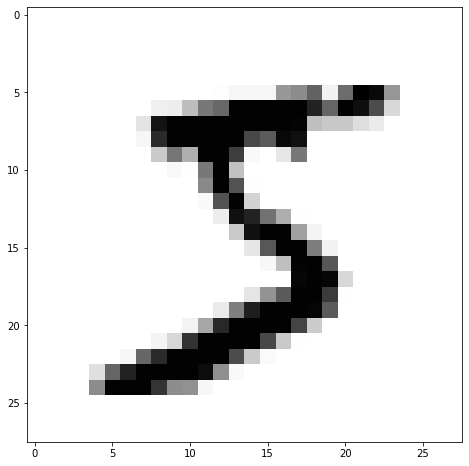

In [ ]:
sample_index = 0
image = train_data[sample_index][0]
label = train_data[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
class ImageDataset(Dataset):

  def __init__(self, dataset, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform

    # Get x and y values from each line and append to self.data

    self.data = []
    to_tensor = torchvision.transforms.ToTensor()
    for d in dataset:
      image = d[0]
      label = d[1]
      image = to_tensor(image)
      #image = torch.reshape(image, (-1,))
      label = torch.tensor(label).long()
      self.data.append((image, label))

    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, sample):
      image = sample[0]
      label = sample[1]
      return (image + torch.randn(image.size()) * self.std + self.mean, image, label)
    
    def __repr__(self):
      return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Convolutional AutoEncoder

In [ ]:
torch.manual_seed(0)
composed_transform = None#transforms.Compose([AddGaussianNoise(0., 1.)])

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            ##############################
            nn.Conv2d(1, 8, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            ##############################


            # Second convolutional layer
            ##############################
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(),
            ##############################


            # Third convolutional layer
            ##############################
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=0),
            ##############################
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            ##############################
            nn.Linear(32 * 3 * 3, 64),
            nn.ReLU(),
            ##############################

            # Second linear layer
            ##############################
             nn.Linear(64, encoded_space_dim),
             nn.ReLU(),
            ##############################
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)

        # Flatten
        x = self.flatten(x)
        
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            ##############################

            # Second linear layer
            ##############################
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True),
  
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First convolutional layer
            ##############################
            nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=2, output_padding=0),
            nn.ReLU(),
            ##############################

            # Second convolutional layer
            ##############################
            nn.ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            ##############################

            # Third convolutional layer
            ##############################
            nn.ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            ##############################
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.decoder_lin(x)

        # Unflatten
        x = self.unflatten(x)
        
        # Apply linear layers
        x = self.decoder_conv(x)

        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
torch.manual_seed(0)
### Initialize the two networks
encoded_space_dim = 4
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-4)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noised = False, verbose = True):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        if noised:
          image = image_batch[0].to(device)
        else:
          image = image_batch[0].to(device)

        # Encode data
        encoded = encoder(image)

        # Decode data
        decoded = decoder(encoded)

        # Evaluate loss
        if noised:
          original = image_batch[1].to(device)
          loss = loss_fn(decoded, original)
        else:
          loss = loss_fn(decoded, image)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print batch loss
        if verbose:
          print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noised = False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            # Move tensor to the proper device
            if noised:
              image = image_batch[0].to(device)
            else:
              image = image_batch[0].to(device)

            # Encode data
            encoded = encoder(image)

            # Decode data
            decoded_data = decoder(encoded)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            if noised:
              conc_label.append(image_batch[1].cpu())
            else:
              conc_label.append(image_batch[0].cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def cross_validation(encoder, decoder, device, loss_fn, optimizer, full_dataset, batch_size, cv=5):

  from sklearn.model_selection import KFold

  kf = KFold(n_splits=cv)
  train_errors = []
  val_errors = []
  count_fold = 0
  for train_indexes, val_indexes in kf.split(full_dataset):
    train_dataset = torch.utils.data.Subset(full_dataset, train_indexes) #Train dataset
    validation_dataset = torch.utils.data.Subset(full_dataset, val_indexes) #Validation Dataset

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)

    train_loss = train_epoch(encoder, decoder, device, train_dataloader, loss_fn, optimizer, verbose=False)

    val_loss = test_epoch(encoder, decoder, device, val_dataloader, loss_fn)

    print("[Fold %d] Train error: %f - Validation Error: %f" % (count_fold, train_loss, val_loss))

    train_errors.append(train_loss)
    val_errors.append(val_loss)
    count_fold += 1

  return np.mean(train_errors), np.mean(val_errors)

In [ ]:
should_train = True

EPOCH 1/40
[Fold 0] Train error: 0.096565 - Validation Error: 0.065691
[Fold 1] Train error: 0.064059 - Validation Error: 0.062971
[Fold 2] Train error: 0.056973 - Validation Error: 0.051550


	 VALIDATION - EPOCH 1/40 - loss: 0.060071


torch.Size([1, 1, 28, 28])


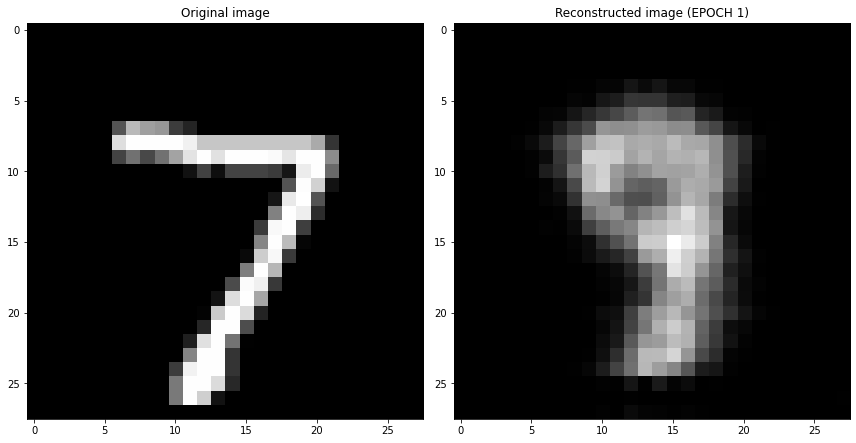

EPOCH 2/40
[Fold 0] Train error: 0.046884 - Validation Error: 0.042707
[Fold 1] Train error: 0.041031 - Validation Error: 0.040230
[Fold 2] Train error: 0.038903 - Validation Error: 0.038280


	 VALIDATION - EPOCH 2/40 - loss: 0.040406


torch.Size([1, 1, 28, 28])


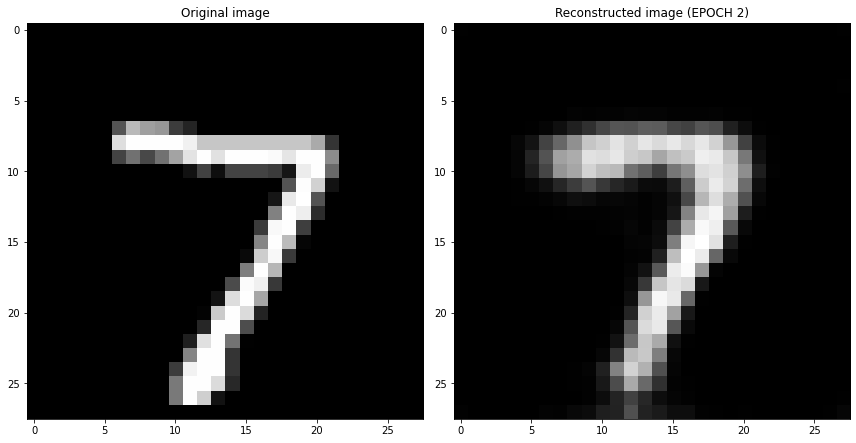

EPOCH 3/40
[Fold 0] Train error: 0.037755 - Validation Error: 0.037237
[Fold 1] Train error: 0.036766 - Validation Error: 0.036785
[Fold 2] Train error: 0.036208 - Validation Error: 0.035956


	 VALIDATION - EPOCH 3/40 - loss: 0.036659


torch.Size([1, 1, 28, 28])


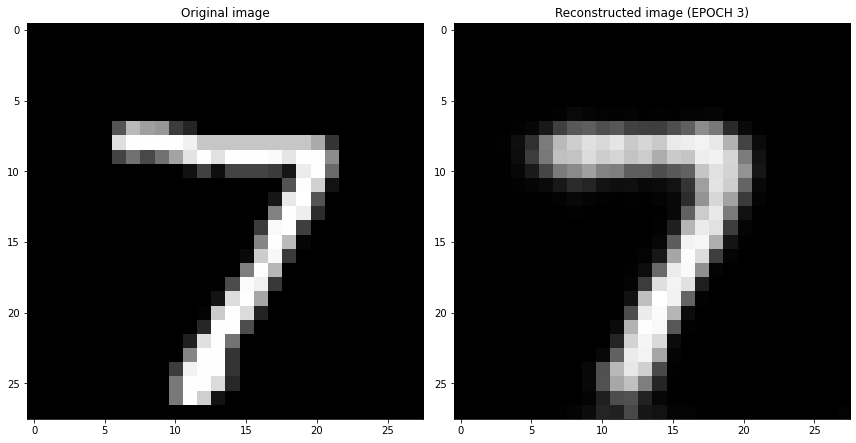

EPOCH 4/40
[Fold 0] Train error: 0.035840 - Validation Error: 0.035597
[Fold 1] Train error: 0.035334 - Validation Error: 0.035500
[Fold 2] Train error: 0.035138 - Validation Error: 0.035039


	 VALIDATION - EPOCH 4/40 - loss: 0.035379


torch.Size([1, 1, 28, 28])


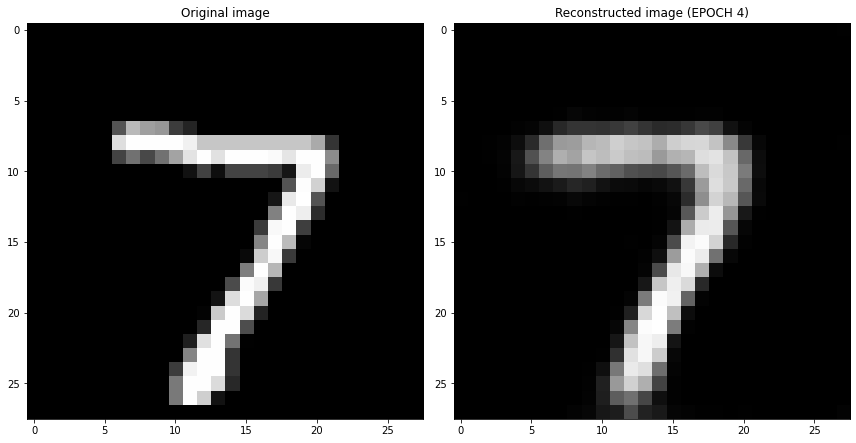

EPOCH 5/40
[Fold 0] Train error: 0.034937 - Validation Error: 0.035150
[Fold 1] Train error: 0.034590 - Validation Error: 0.034757
[Fold 2] Train error: 0.034507 - Validation Error: 0.034398


	 VALIDATION - EPOCH 5/40 - loss: 0.034768


torch.Size([1, 1, 28, 28])


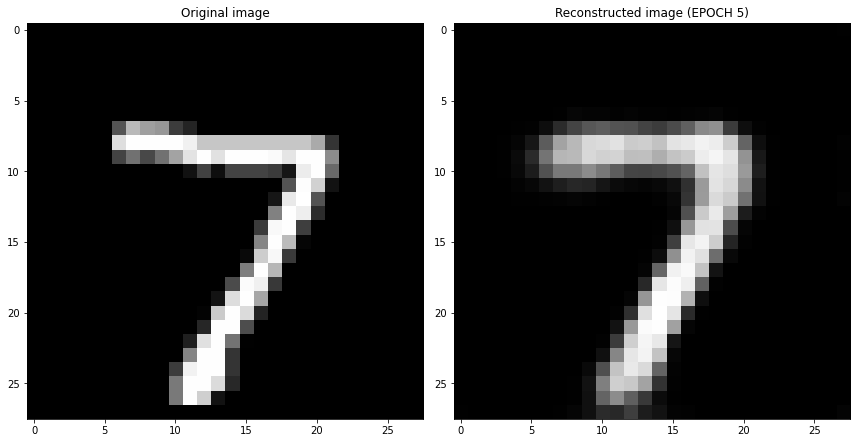

EPOCH 6/40
[Fold 0] Train error: 0.034361 - Validation Error: 0.034229
[Fold 1] Train error: 0.034041 - Validation Error: 0.034465
[Fold 2] Train error: 0.034041 - Validation Error: 0.034028


	 VALIDATION - EPOCH 6/40 - loss: 0.034241


torch.Size([1, 1, 28, 28])


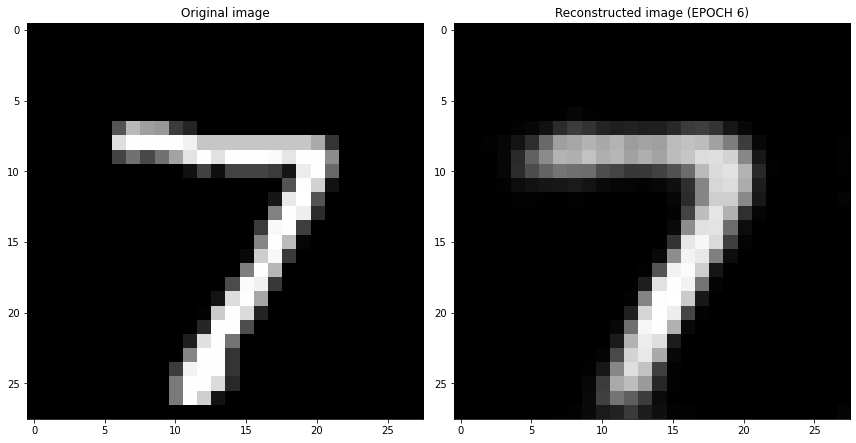

EPOCH 7/40
[Fold 0] Train error: 0.033958 - Validation Error: 0.033717
[Fold 1] Train error: 0.033672 - Validation Error: 0.033849
[Fold 2] Train error: 0.033705 - Validation Error: 0.033436


	 VALIDATION - EPOCH 7/40 - loss: 0.033667


torch.Size([1, 1, 28, 28])


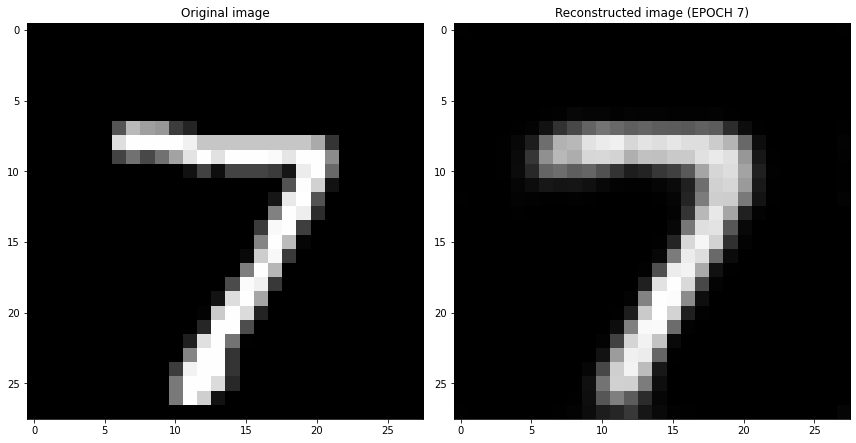

EPOCH 8/40
[Fold 0] Train error: 0.033675 - Validation Error: 0.033369
[Fold 1] Train error: 0.033428 - Validation Error: 0.033699
[Fold 2] Train error: 0.033454 - Validation Error: 0.033363


	 VALIDATION - EPOCH 8/40 - loss: 0.033477


torch.Size([1, 1, 28, 28])


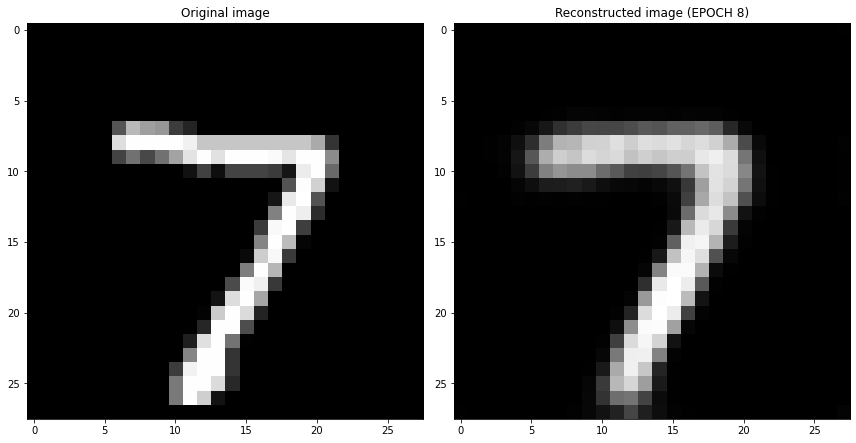

EPOCH 9/40
[Fold 0] Train error: 0.033395 - Validation Error: 0.033390
[Fold 1] Train error: 0.033200 - Validation Error: 0.033392
[Fold 2] Train error: 0.033287 - Validation Error: 0.033111


	 VALIDATION - EPOCH 9/40 - loss: 0.033298


torch.Size([1, 1, 28, 28])


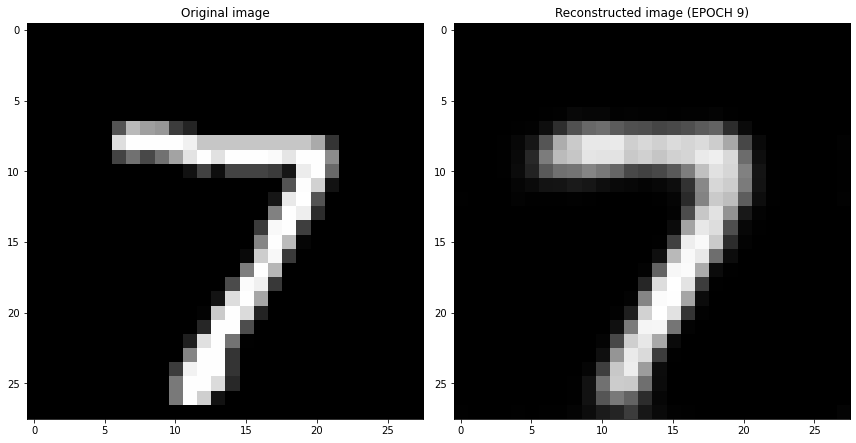

EPOCH 10/40
[Fold 0] Train error: 0.033193 - Validation Error: 0.033185
[Fold 1] Train error: 0.033059 - Validation Error: 0.033280
[Fold 2] Train error: 0.033107 - Validation Error: 0.033106


	 VALIDATION - EPOCH 10/40 - loss: 0.033190


torch.Size([1, 1, 28, 28])


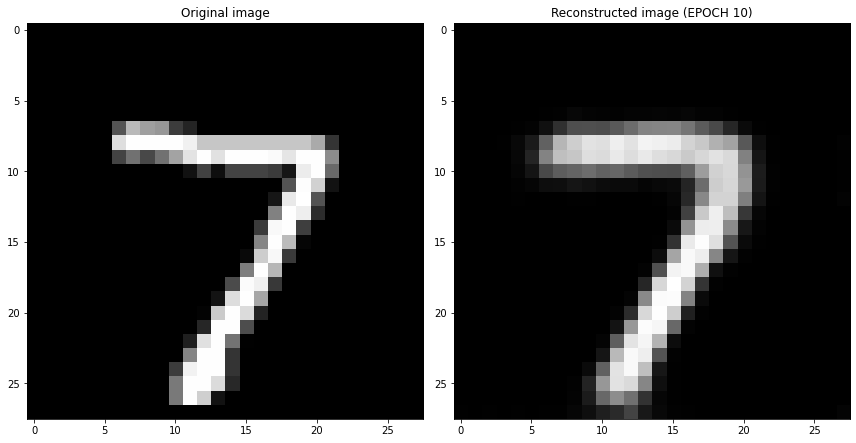

EPOCH 11/40
[Fold 0] Train error: 0.033020 - Validation Error: 0.032947
[Fold 1] Train error: 0.032848 - Validation Error: 0.033292
[Fold 2] Train error: 0.032978 - Validation Error: 0.032799


	 VALIDATION - EPOCH 11/40 - loss: 0.033013


torch.Size([1, 1, 28, 28])


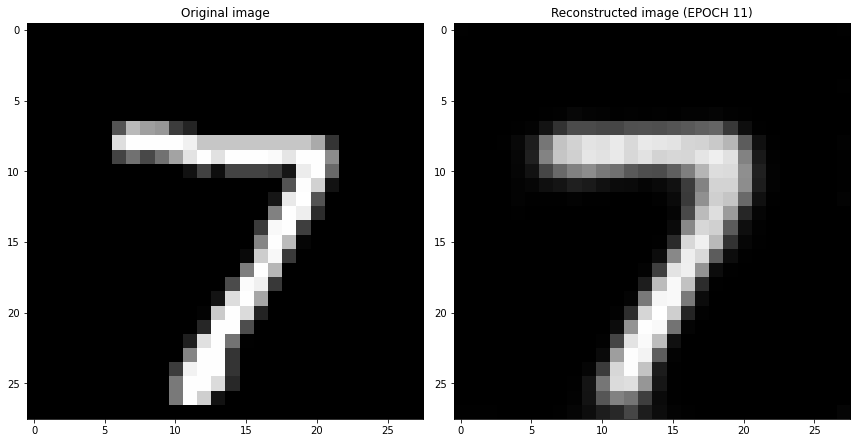

EPOCH 12/40
[Fold 0] Train error: 0.032918 - Validation Error: 0.032808
[Fold 1] Train error: 0.032721 - Validation Error: 0.033082
[Fold 2] Train error: 0.032852 - Validation Error: 0.032902


	 VALIDATION - EPOCH 12/40 - loss: 0.032931


torch.Size([1, 1, 28, 28])


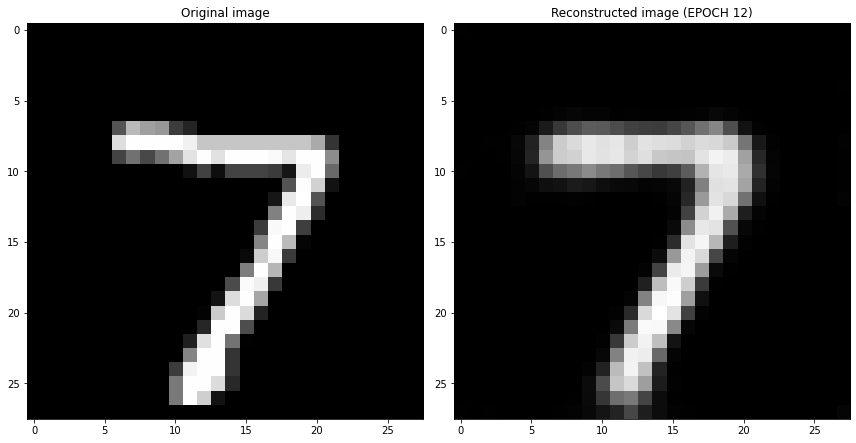

EPOCH 13/40
[Fold 0] Train error: 0.032808 - Validation Error: 0.032834
[Fold 1] Train error: 0.032608 - Validation Error: 0.032975
[Fold 2] Train error: 0.032742 - Validation Error: 0.032805


	 VALIDATION - EPOCH 13/40 - loss: 0.032871


torch.Size([1, 1, 28, 28])


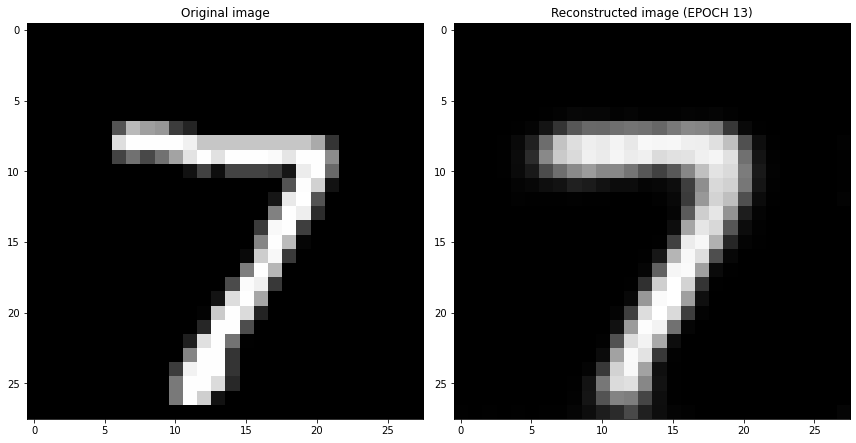

EPOCH 14/40
[Fold 0] Train error: 0.032704 - Validation Error: 0.032485
[Fold 1] Train error: 0.032531 - Validation Error: 0.032860
[Fold 2] Train error: 0.032592 - Validation Error: 0.032514


	 VALIDATION - EPOCH 14/40 - loss: 0.032620


torch.Size([1, 1, 28, 28])


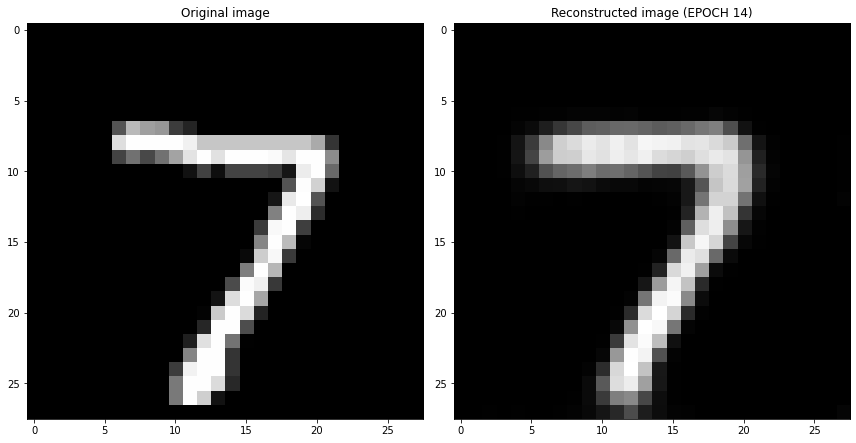

EPOCH 15/40
[Fold 0] Train error: 0.032581 - Validation Error: 0.032349
[Fold 1] Train error: 0.032402 - Validation Error: 0.032733
[Fold 2] Train error: 0.032524 - Validation Error: 0.032571


	 VALIDATION - EPOCH 15/40 - loss: 0.032551


torch.Size([1, 1, 28, 28])


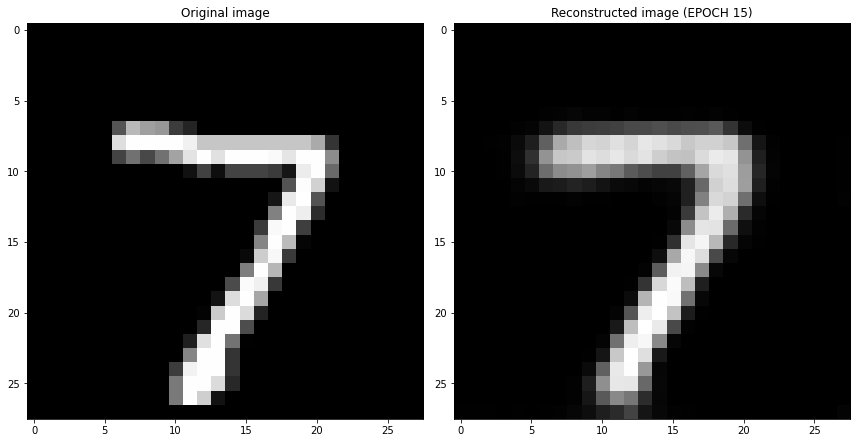

EPOCH 16/40
[Fold 0] Train error: 0.032520 - Validation Error: 0.032437
[Fold 1] Train error: 0.032345 - Validation Error: 0.032720
[Fold 2] Train error: 0.032408 - Validation Error: 0.032322


	 VALIDATION - EPOCH 16/40 - loss: 0.032493


torch.Size([1, 1, 28, 28])


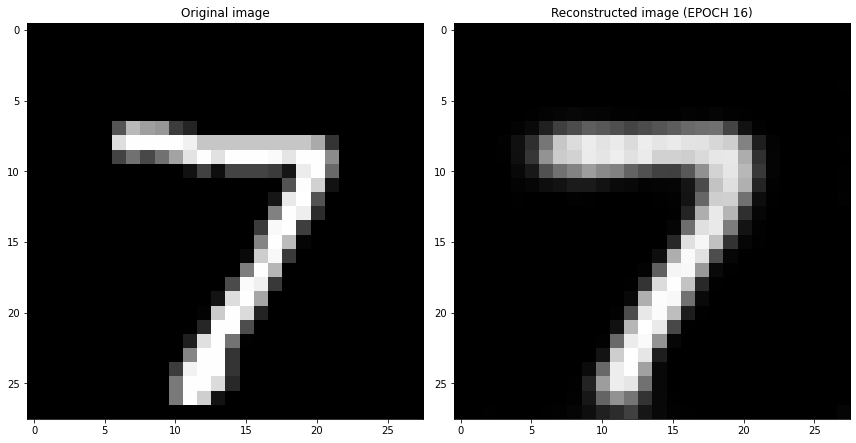

EPOCH 17/40
[Fold 0] Train error: 0.032419 - Validation Error: 0.032388
[Fold 1] Train error: 0.032271 - Validation Error: 0.032746
[Fold 2] Train error: 0.032381 - Validation Error: 0.032401


	 VALIDATION - EPOCH 17/40 - loss: 0.032511


torch.Size([1, 1, 28, 28])


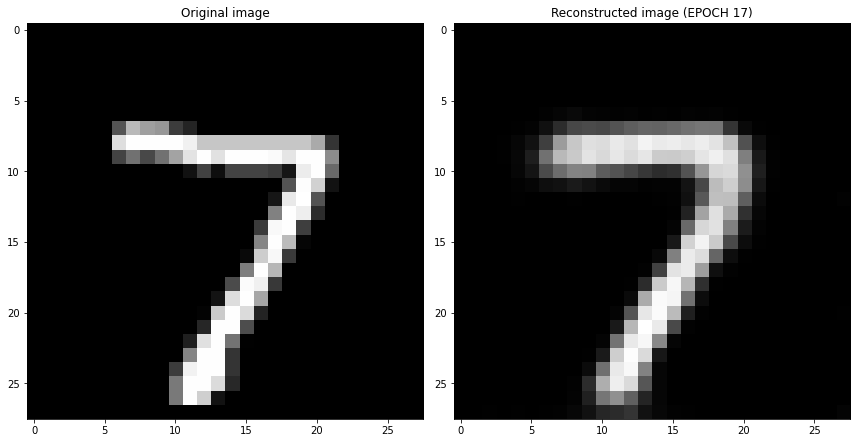

EPOCH 18/40
[Fold 0] Train error: 0.032367 - Validation Error: 0.032125
[Fold 1] Train error: 0.032173 - Validation Error: 0.032422
[Fold 2] Train error: 0.032259 - Validation Error: 0.032303


	 VALIDATION - EPOCH 18/40 - loss: 0.032283


torch.Size([1, 1, 28, 28])


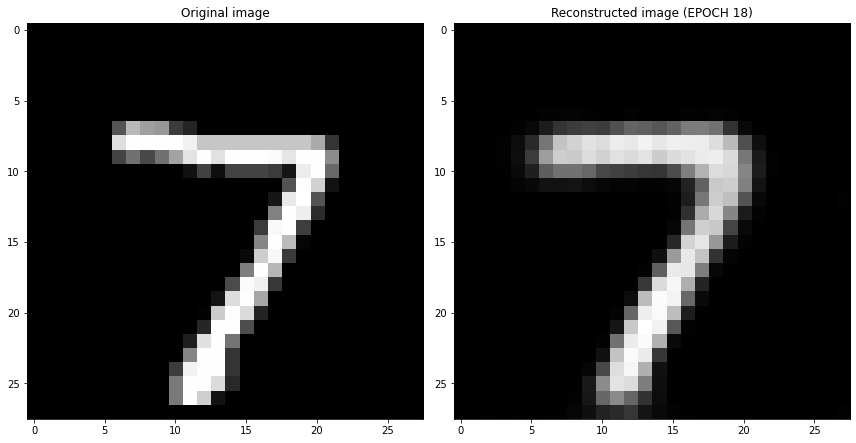

EPOCH 19/40
[Fold 0] Train error: 0.032302 - Validation Error: 0.032161
[Fold 1] Train error: 0.032113 - Validation Error: 0.032402
[Fold 2] Train error: 0.032242 - Validation Error: 0.032171


	 VALIDATION - EPOCH 19/40 - loss: 0.032245


torch.Size([1, 1, 28, 28])


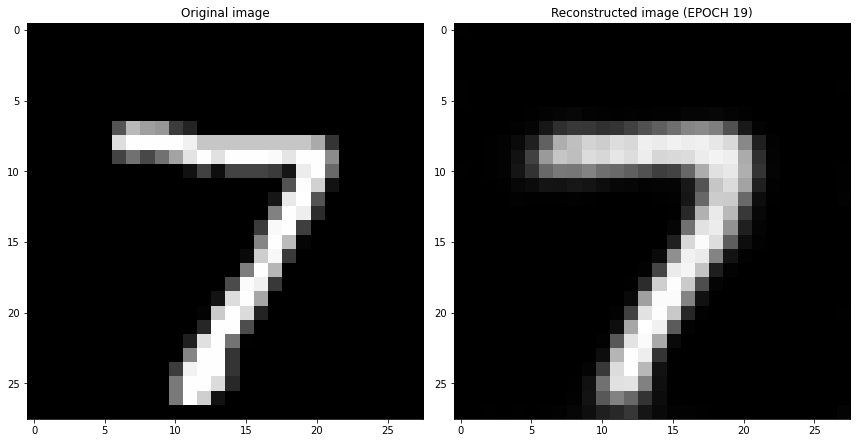

EPOCH 20/40
[Fold 0] Train error: 0.032225 - Validation Error: 0.032174
[Fold 1] Train error: 0.032096 - Validation Error: 0.032304
[Fold 2] Train error: 0.032166 - Validation Error: 0.032013


	 VALIDATION - EPOCH 20/40 - loss: 0.032164


torch.Size([1, 1, 28, 28])


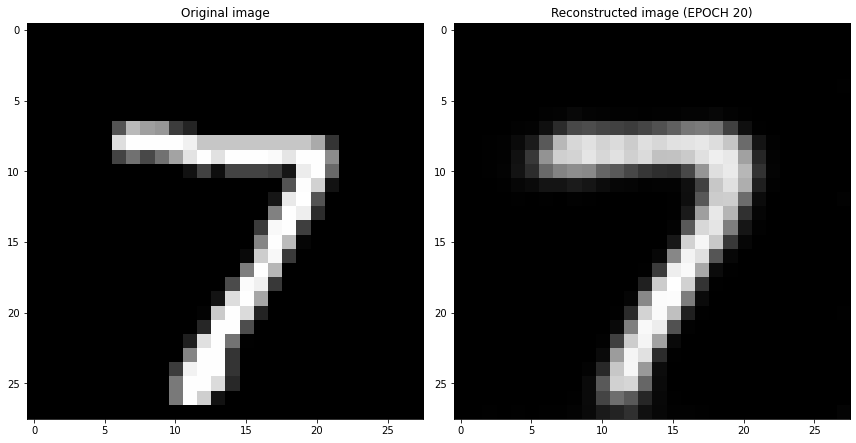

EPOCH 21/40
[Fold 0] Train error: 0.032160 - Validation Error: 0.032021
[Fold 1] Train error: 0.032058 - Validation Error: 0.032470
[Fold 2] Train error: 0.032148 - Validation Error: 0.031987


	 VALIDATION - EPOCH 21/40 - loss: 0.032159


torch.Size([1, 1, 28, 28])


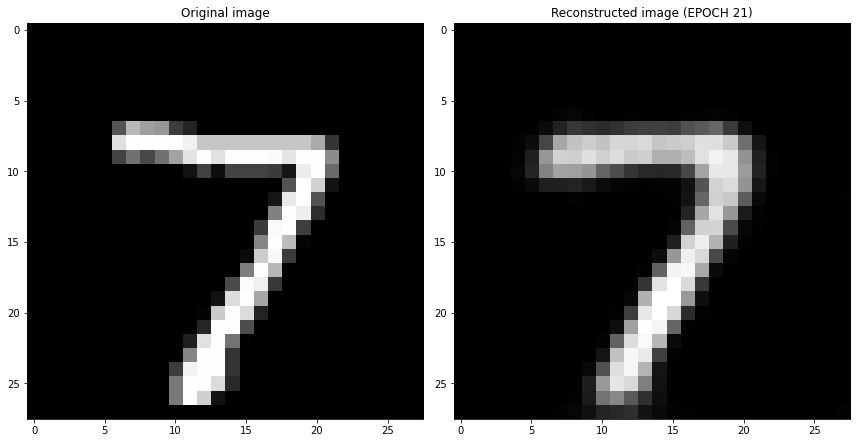

EPOCH 22/40
[Fold 0] Train error: 0.032145 - Validation Error: 0.031951
[Fold 1] Train error: 0.031991 - Validation Error: 0.032357
[Fold 2] Train error: 0.032121 - Validation Error: 0.032124


	 VALIDATION - EPOCH 22/40 - loss: 0.032144


torch.Size([1, 1, 28, 28])


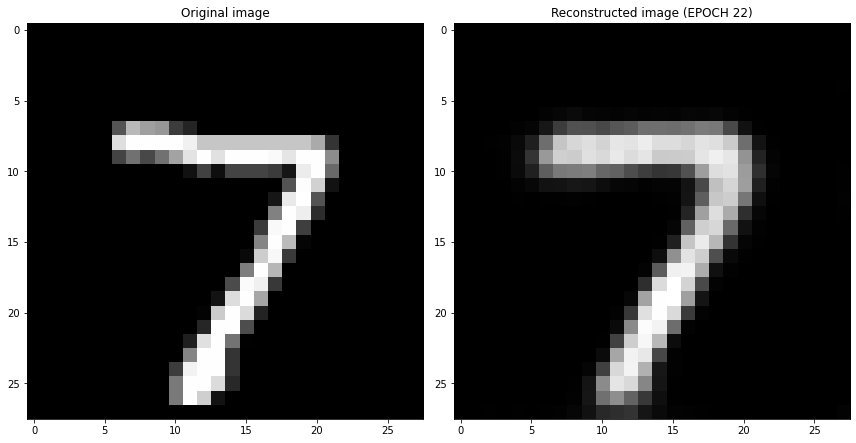

EPOCH 23/40
[Fold 0] Train error: 0.032135 - Validation Error: 0.031881
[Fold 1] Train error: 0.031916 - Validation Error: 0.032406
[Fold 2] Train error: 0.032066 - Validation Error: 0.032099


	 VALIDATION - EPOCH 23/40 - loss: 0.032129


torch.Size([1, 1, 28, 28])


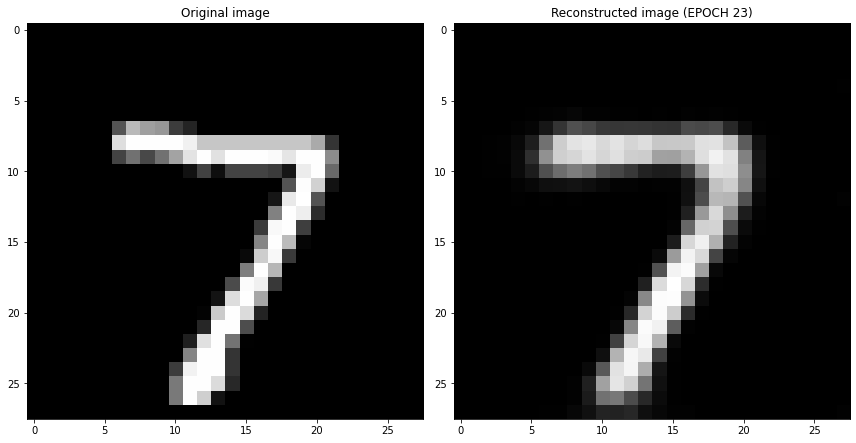

EPOCH 24/40
[Fold 0] Train error: 0.032089 - Validation Error: 0.031875
[Fold 1] Train error: 0.031916 - Validation Error: 0.032172
[Fold 2] Train error: 0.032043 - Validation Error: 0.031984


	 VALIDATION - EPOCH 24/40 - loss: 0.032010


torch.Size([1, 1, 28, 28])


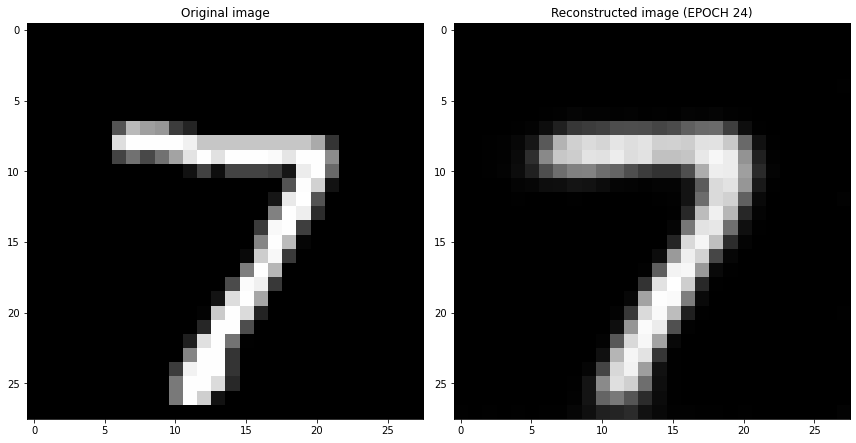

EPOCH 25/40
[Fold 0] Train error: 0.032062 - Validation Error: 0.031990
[Fold 1] Train error: 0.031934 - Validation Error: 0.032197
[Fold 2] Train error: 0.032012 - Validation Error: 0.031936


	 VALIDATION - EPOCH 25/40 - loss: 0.032041


torch.Size([1, 1, 28, 28])


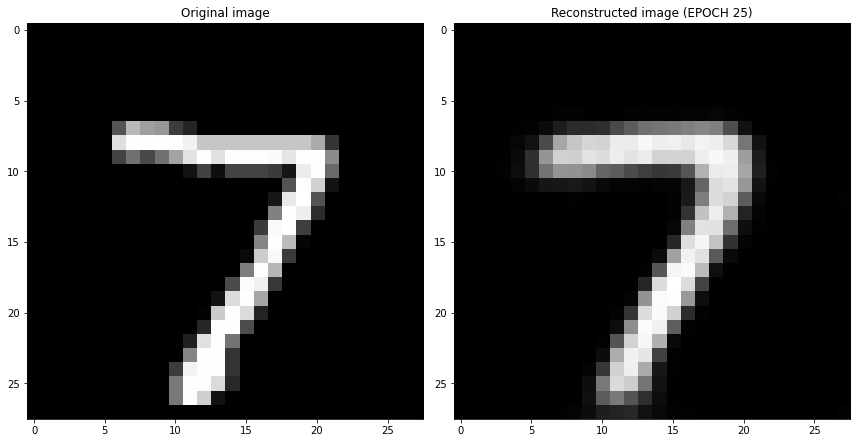

EPOCH 26/40
[Fold 0] Train error: 0.032011 - Validation Error: 0.031970
[Fold 1] Train error: 0.031847 - Validation Error: 0.032358
[Fold 2] Train error: 0.031991 - Validation Error: 0.031889


	 VALIDATION - EPOCH 26/40 - loss: 0.032072


torch.Size([1, 1, 28, 28])


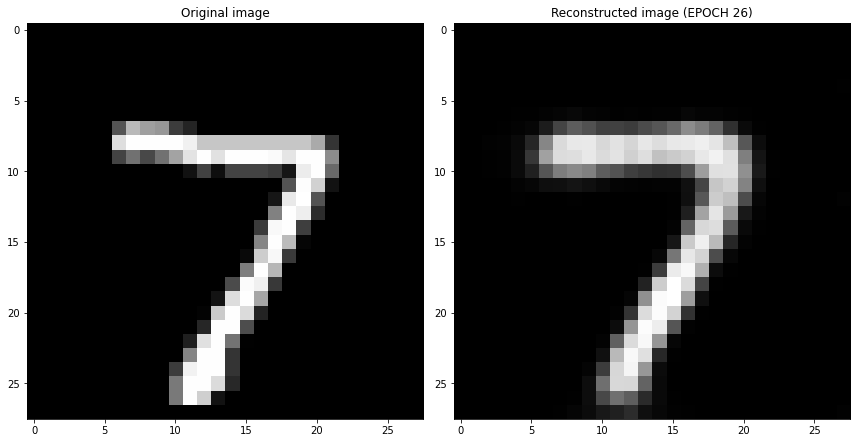

EPOCH 27/40
[Fold 0] Train error: 0.031976 - Validation Error: 0.031749
[Fold 1] Train error: 0.031857 - Validation Error: 0.032079
[Fold 2] Train error: 0.031949 - Validation Error: 0.031921


	 VALIDATION - EPOCH 27/40 - loss: 0.031917


torch.Size([1, 1, 28, 28])


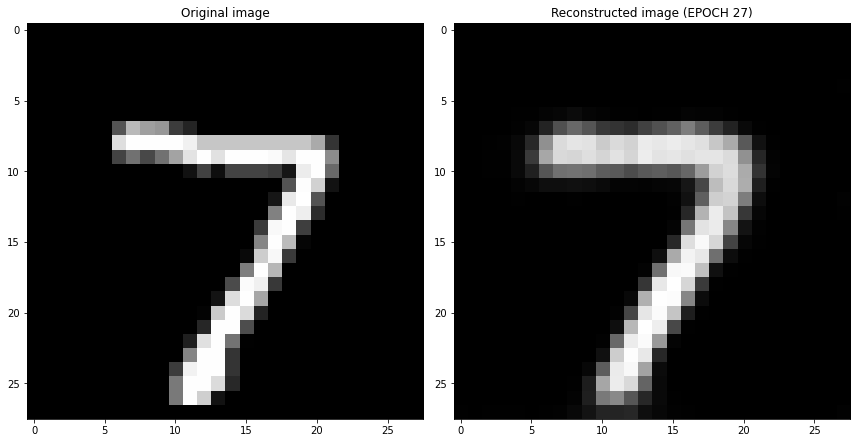

EPOCH 28/40
[Fold 0] Train error: 0.031979 - Validation Error: 0.031734
[Fold 1] Train error: 0.031816 - Validation Error: 0.032169
[Fold 2] Train error: 0.031930 - Validation Error: 0.031861


	 VALIDATION - EPOCH 28/40 - loss: 0.031921


torch.Size([1, 1, 28, 28])


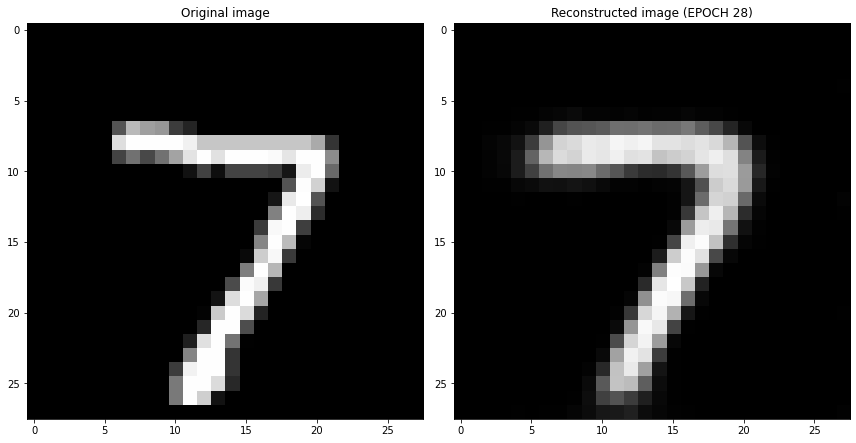

EPOCH 29/40
[Fold 0] Train error: 0.031957 - Validation Error: 0.031860
[Fold 1] Train error: 0.031806 - Validation Error: 0.031991
[Fold 2] Train error: 0.031863 - Validation Error: 0.031864


	 VALIDATION - EPOCH 29/40 - loss: 0.031905


torch.Size([1, 1, 28, 28])


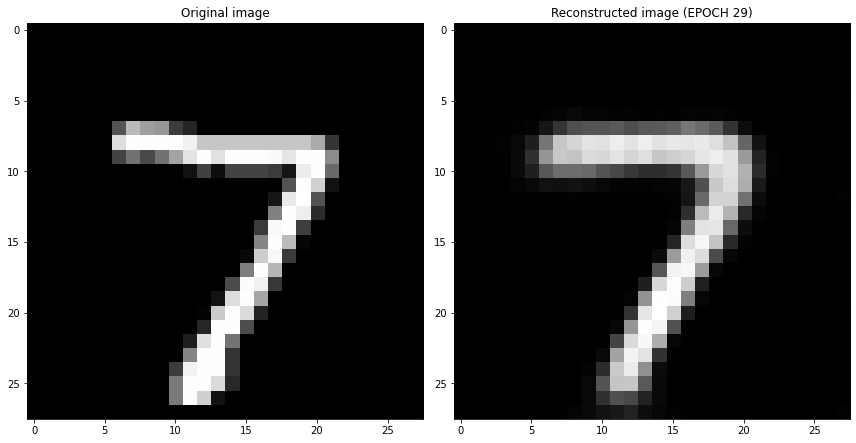

EPOCH 30/40
[Fold 0] Train error: 0.031939 - Validation Error: 0.031762
[Fold 1] Train error: 0.031740 - Validation Error: 0.032146
[Fold 2] Train error: 0.031875 - Validation Error: 0.031733


	 VALIDATION - EPOCH 30/40 - loss: 0.031881


torch.Size([1, 1, 28, 28])


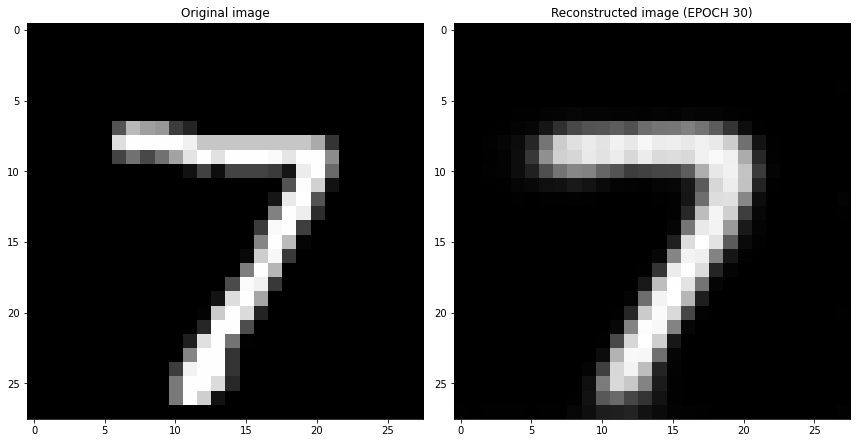

EPOCH 31/40
[Fold 0] Train error: 0.031921 - Validation Error: 0.031822
[Fold 1] Train error: 0.031708 - Validation Error: 0.032002
[Fold 2] Train error: 0.031832 - Validation Error: 0.031824


	 VALIDATION - EPOCH 31/40 - loss: 0.031883


torch.Size([1, 1, 28, 28])


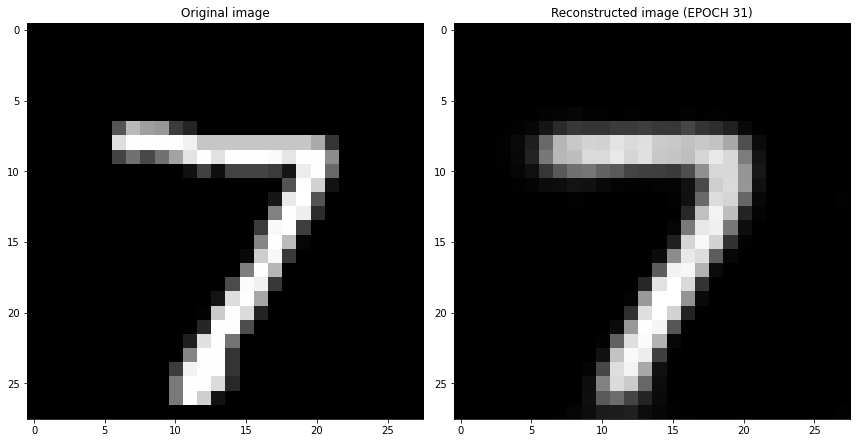

EPOCH 32/40
[Fold 0] Train error: 0.031867 - Validation Error: 0.031776
[Fold 1] Train error: 0.031660 - Validation Error: 0.031960
[Fold 2] Train error: 0.031823 - Validation Error: 0.031852


	 VALIDATION - EPOCH 32/40 - loss: 0.031863


torch.Size([1, 1, 28, 28])


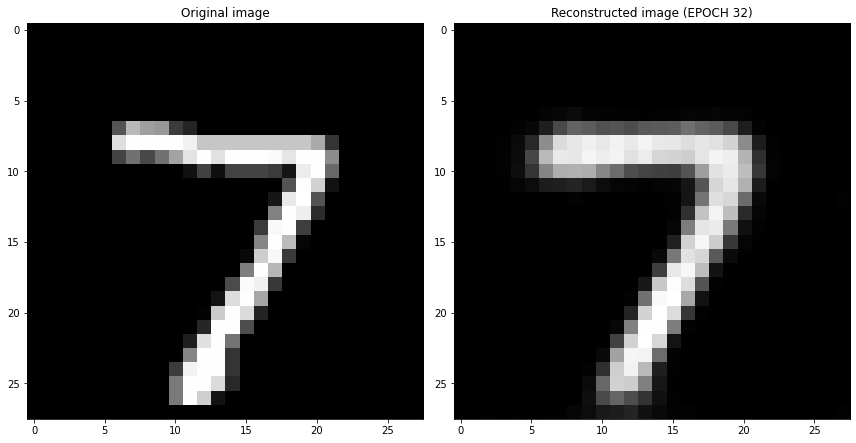

EPOCH 33/40
[Fold 0] Train error: 0.031850 - Validation Error: 0.031741
[Fold 1] Train error: 0.031702 - Validation Error: 0.032127
[Fold 2] Train error: 0.031755 - Validation Error: 0.031753


	 VALIDATION - EPOCH 33/40 - loss: 0.031874


torch.Size([1, 1, 28, 28])


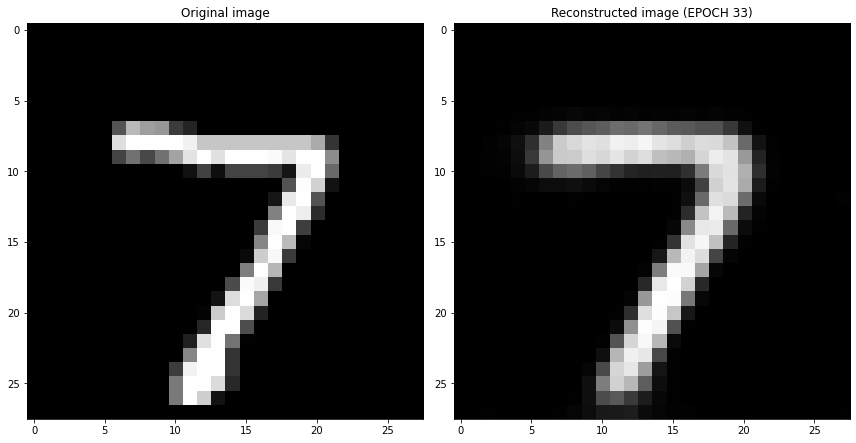

EPOCH 34/40
[Fold 0] Train error: 0.031803 - Validation Error: 0.031587
[Fold 1] Train error: 0.031670 - Validation Error: 0.031871
[Fold 2] Train error: 0.031825 - Validation Error: 0.031675


	 VALIDATION - EPOCH 34/40 - loss: 0.031711


torch.Size([1, 1, 28, 28])


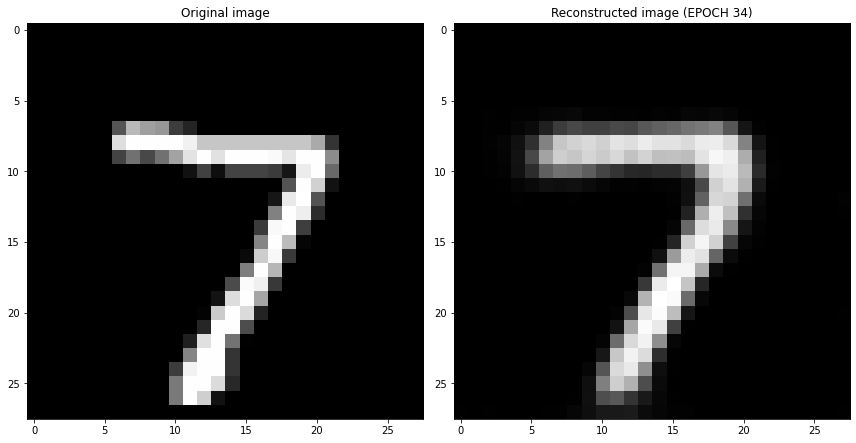

EPOCH 35/40
[Fold 0] Train error: 0.031819 - Validation Error: 0.031572
[Fold 1] Train error: 0.031633 - Validation Error: 0.031876
[Fold 2] Train error: 0.031738 - Validation Error: 0.031686


	 VALIDATION - EPOCH 35/40 - loss: 0.031711


torch.Size([1, 1, 28, 28])


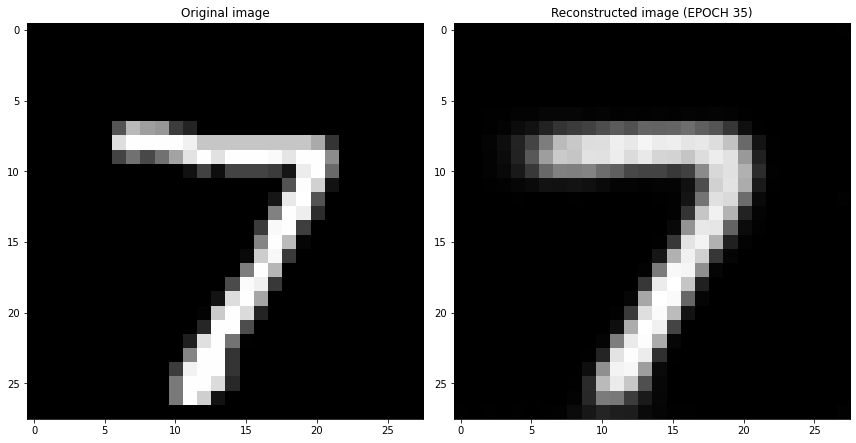

EPOCH 36/40
[Fold 0] Train error: 0.031774 - Validation Error: 0.031844
[Fold 1] Train error: 0.031650 - Validation Error: 0.032050
[Fold 2] Train error: 0.031717 - Validation Error: 0.031659


	 VALIDATION - EPOCH 36/40 - loss: 0.031851


torch.Size([1, 1, 28, 28])


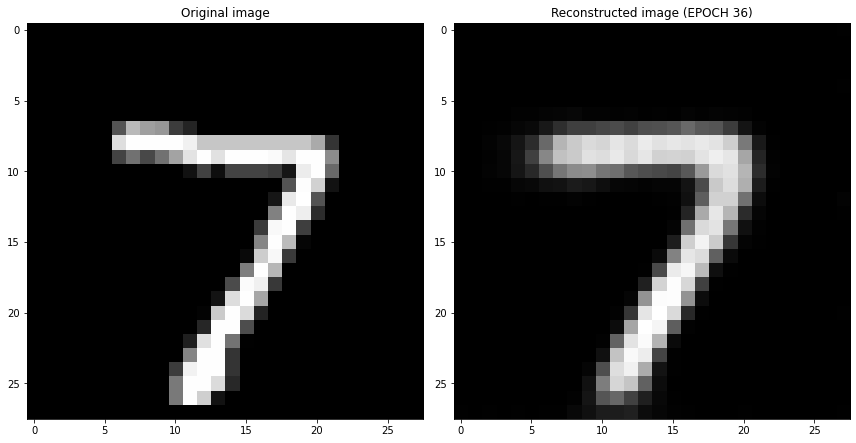

EPOCH 37/40
[Fold 0] Train error: 0.031777 - Validation Error: 0.031548
[Fold 1] Train error: 0.031621 - Validation Error: 0.031872
[Fold 2] Train error: 0.031714 - Validation Error: 0.031831


	 VALIDATION - EPOCH 37/40 - loss: 0.031750


torch.Size([1, 1, 28, 28])


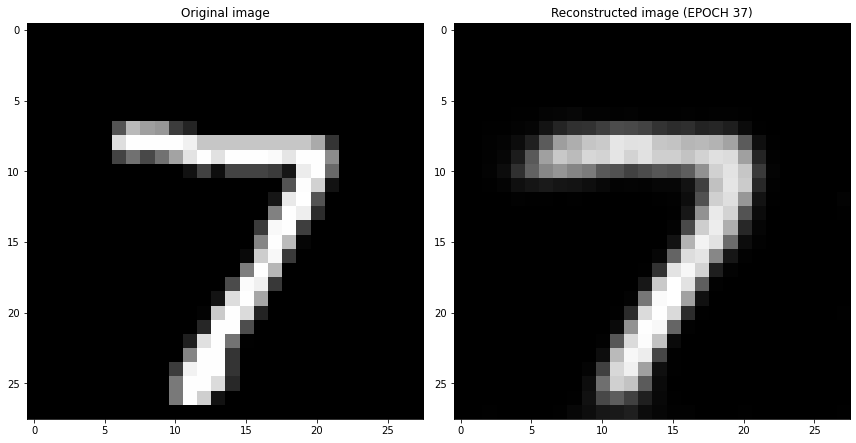

EPOCH 38/40
[Fold 0] Train error: 0.031766 - Validation Error: 0.031533
[Fold 1] Train error: 0.031606 - Validation Error: 0.031875
[Fold 2] Train error: 0.031734 - Validation Error: 0.031748


	 VALIDATION - EPOCH 38/40 - loss: 0.031718


torch.Size([1, 1, 28, 28])


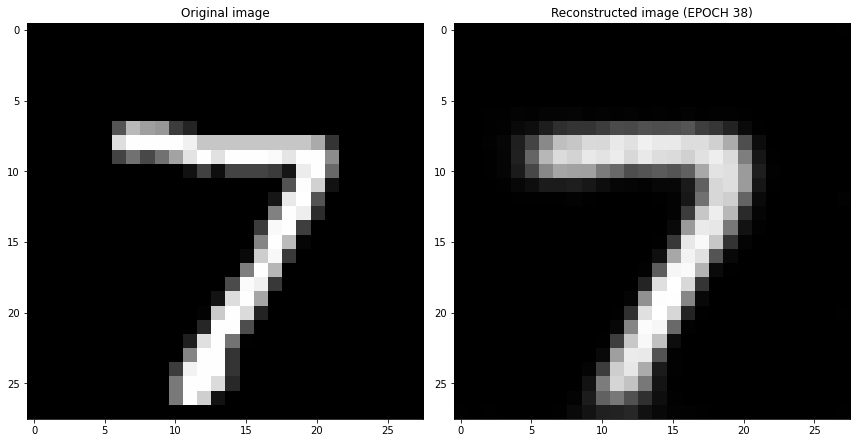

EPOCH 39/40
[Fold 0] Train error: 0.031709 - Validation Error: 0.031582
[Fold 1] Train error: 0.031538 - Validation Error: 0.031898
[Fold 2] Train error: 0.031677 - Validation Error: 0.031761


	 VALIDATION - EPOCH 39/40 - loss: 0.031747


torch.Size([1, 1, 28, 28])


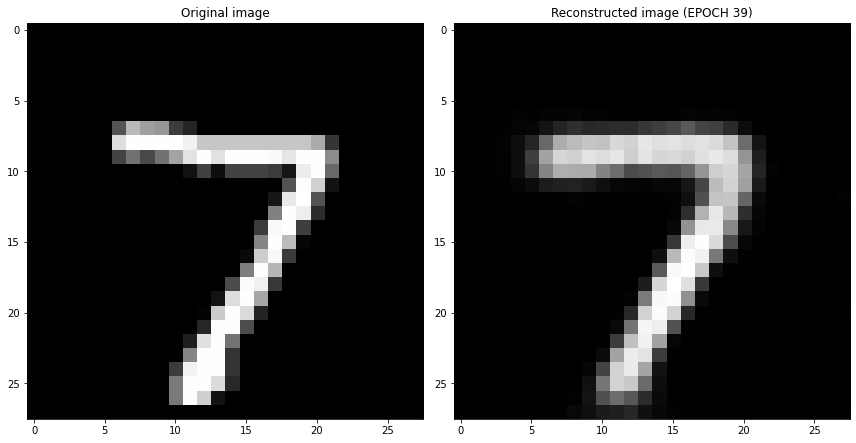

EPOCH 40/40
[Fold 0] Train error: 0.031737 - Validation Error: 0.031771
[Fold 1] Train error: 0.031586 - Validation Error: 0.032063
[Fold 2] Train error: 0.031665 - Validation Error: 0.031681


	 VALIDATION - EPOCH 40/40 - loss: 0.031839


torch.Size([1, 1, 28, 28])


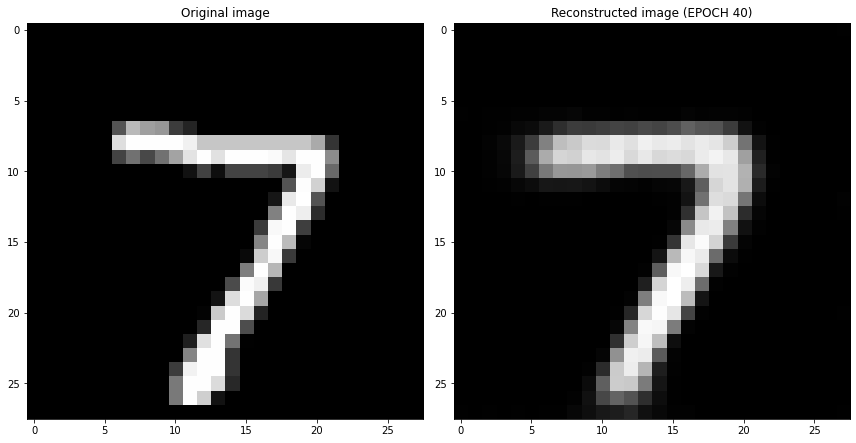

In [ ]:
if should_train:
  ### Training cycle
  num_epochs = 40
  train_loss_log = []
  val_loss_log = []
  for epoch in range(num_epochs):
      print('EPOCH %d/%d' % (epoch + 1, num_epochs))
      ### Training (use the training function)
      train_loss, val_loss = cross_validation(encoder, decoder, device, loss_fn, optim, full_dataset, 128, 3)
      # Print Validationloss
      print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

      train_loss_log.append(train_loss)
      val_loss_log.append(val_loss)
      ### Plot progress
      # Get the output of a specific image (the test image at index 0 in this case)
      img = test_dataset[0][0].unsqueeze(0).to(device)
      print(img.shape)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
          encoded = encoder(img)
          rec_img  = decoder(encoded)
      # Plot the reconstructed image
      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Original image')
      axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
      plt.tight_layout()
      plt.pause(0.1)
      # Save figures
      os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
      fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
      plt.show()
      plt.close()

      # Save network parameters
      torch.save(encoder.state_dict(), 'encoder_params.pth')
      torch.save(decoder.state_dict(), 'decoder_params.pth')

      # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training
else: #Load the model
  encoder.load_state_dict(torch.load('encoder_params.pth'))
  decoder.load_state_dict(torch.load('decoder_params.pth'))


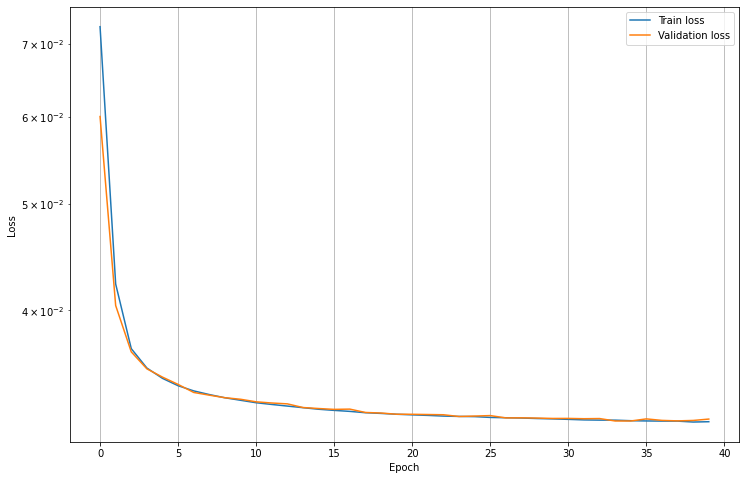

In [ ]:
if should_train:
  plt.figure(figsize=(12,8))
  plt.semilogy(train_loss_log, label='Train loss')
  plt.semilogy(val_loss_log, label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()

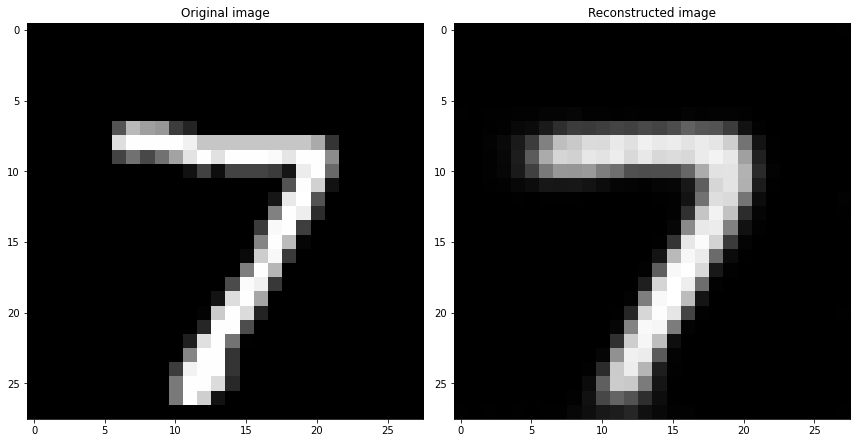

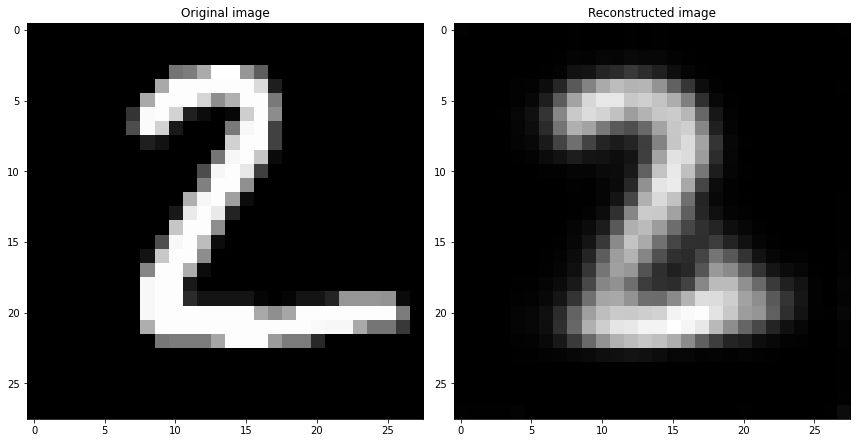

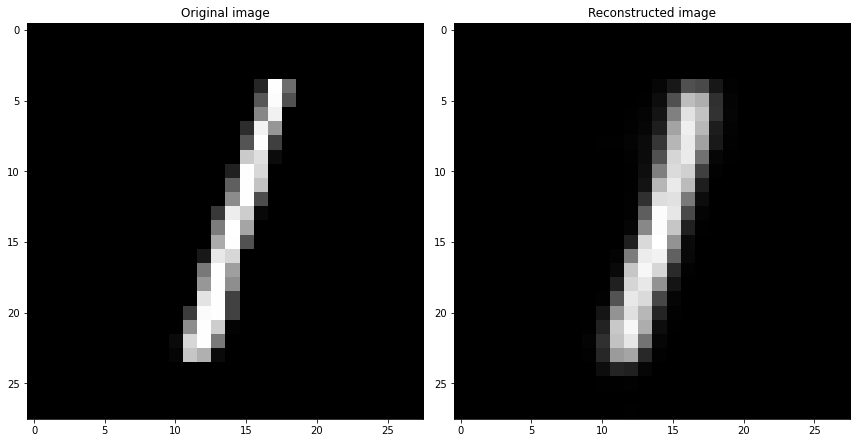

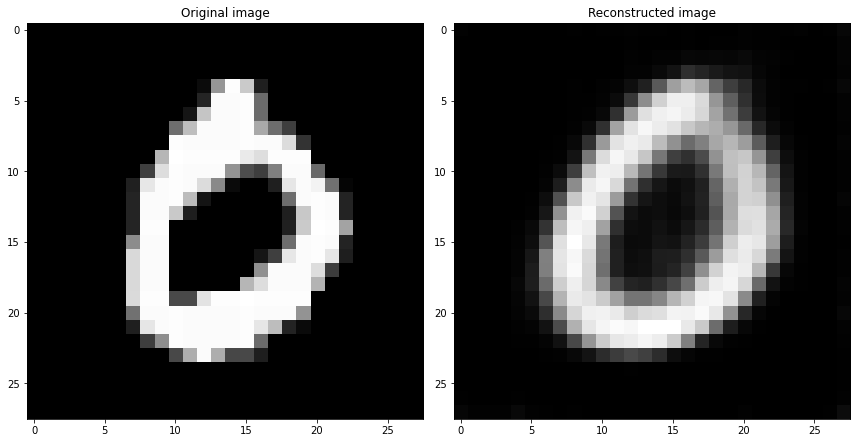

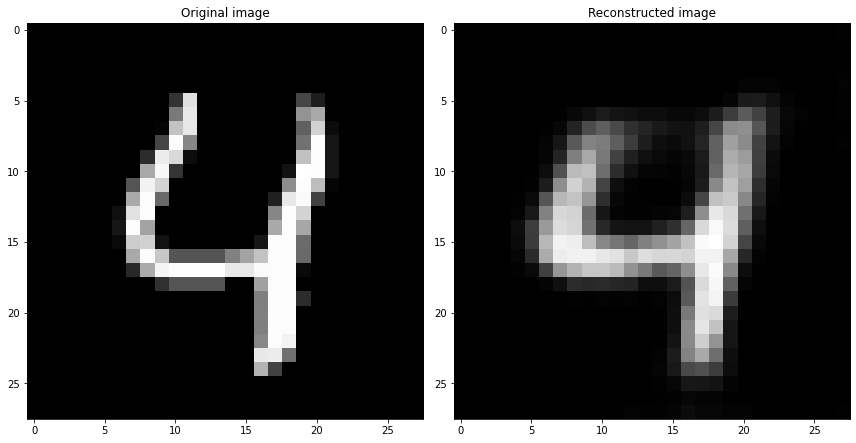

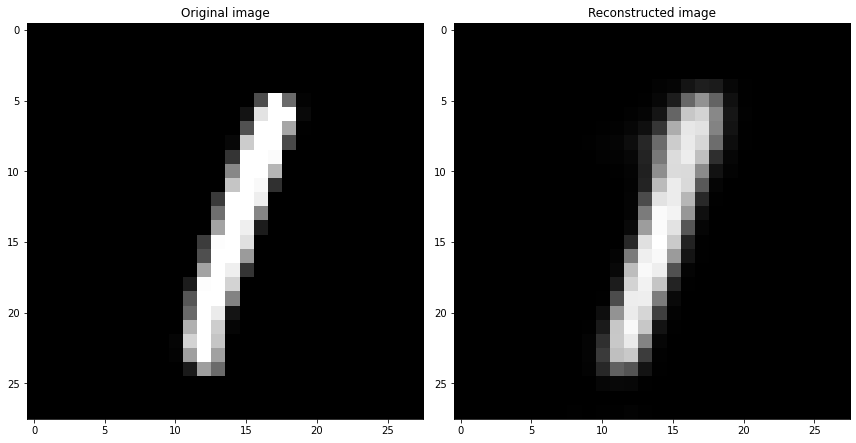

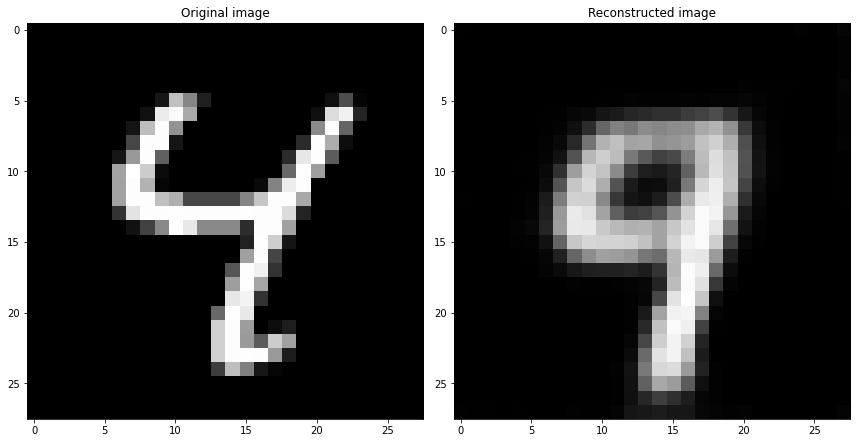

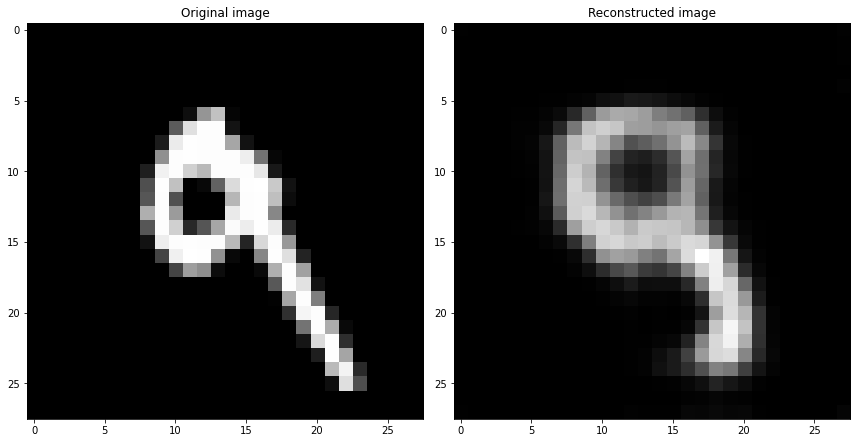

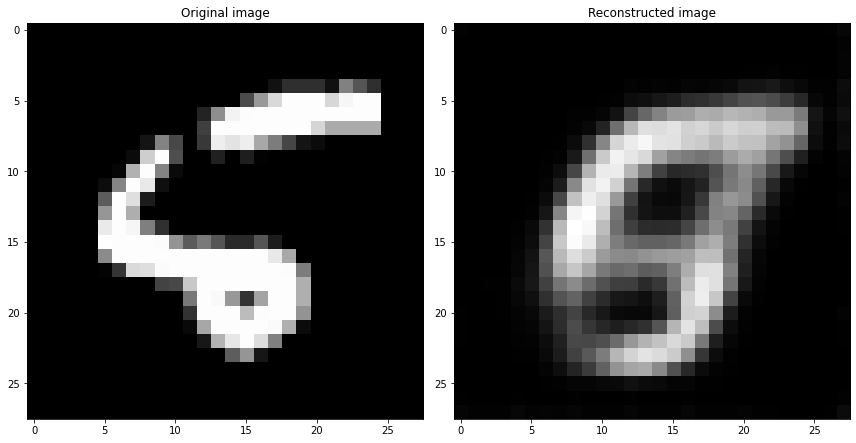

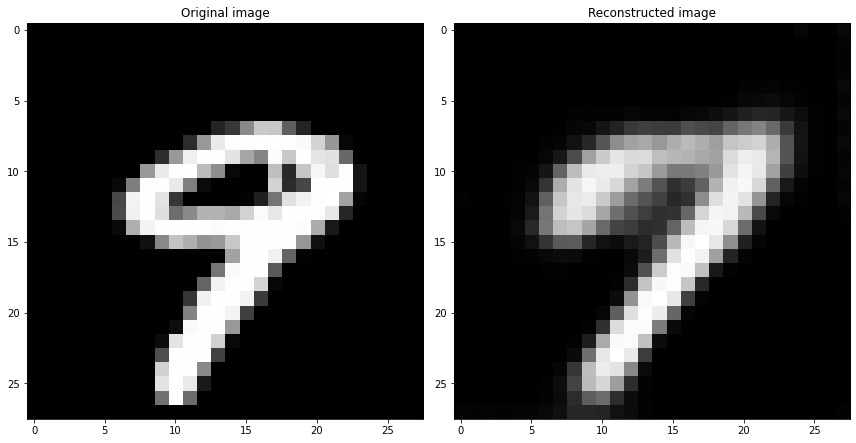

In [ ]:
with torch.no_grad():
  for image_batch in test_dataloader:
    for i in range(10):
      original = image_batch[0].to(device)
      encoded = encoder(original)
      reconstructed = decoder(encoded)
      reconstructed = reconstructed[i][0]
      original = original[i]

      fig, axs = plt.subplots(1, 2, figsize=(12,6))
      axs[0].imshow(original.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Original image')
      axs[1].imshow(reconstructed.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image')
      plt.tight_layout()
      plt.pause(0.1)
    break

# Denoising AutoEncoder

In [ ]:
composed_transform = transforms.Compose([AddGaussianNoise(0., 1.)])

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

In [ ]:
denoise_encoder = Encoder(encoded_space_dim=encoded_space_dim)
denoise_decoder = Decoder(encoded_space_dim=encoded_space_dim)
denoise_encoder = denoise_encoder.to(device)
denoise_decoder = denoise_decoder.to(device)

In [ ]:
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': denoise_encoder.parameters()},
    {'params': denoise_decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

EPOCH 1/5


	 VALIDATION - EPOCH 1/5 - loss: 0.063931


torch.Size([1, 1, 28, 28])


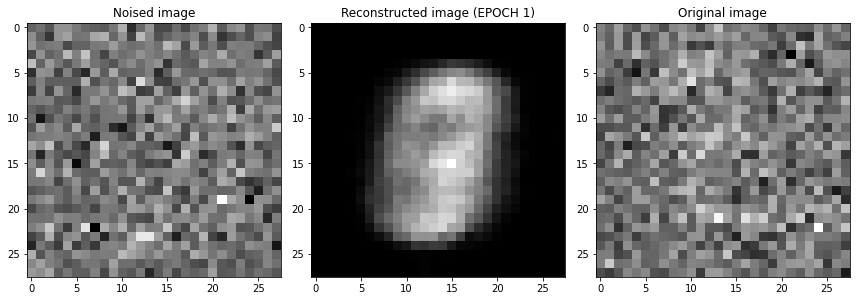

EPOCH 2/5


	 VALIDATION - EPOCH 2/5 - loss: 0.054976


torch.Size([1, 1, 28, 28])


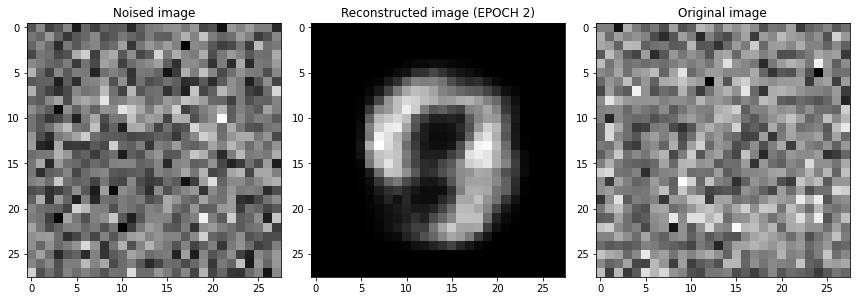

EPOCH 3/5


	 VALIDATION - EPOCH 3/5 - loss: 0.051678


torch.Size([1, 1, 28, 28])


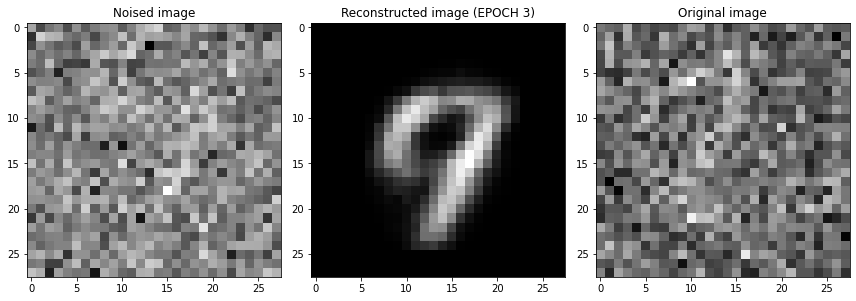

EPOCH 4/5


	 VALIDATION - EPOCH 4/5 - loss: 0.049721


torch.Size([1, 1, 28, 28])


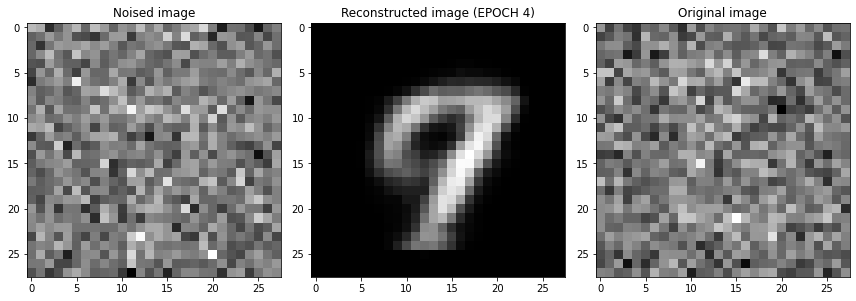

EPOCH 5/5


	 VALIDATION - EPOCH 5/5 - loss: 0.048040


torch.Size([1, 1, 28, 28])


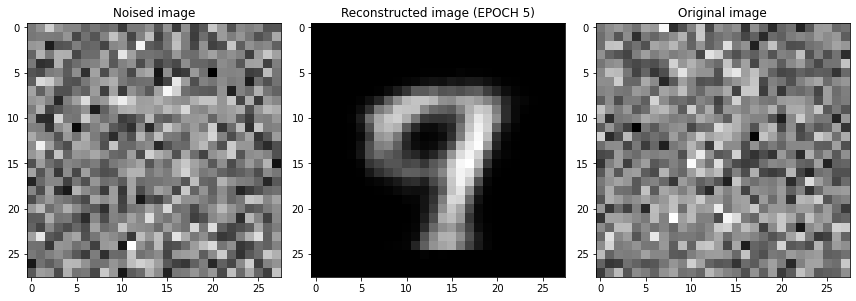

In [ ]:
### Training cycle
if should_train:
  num_epochs = 5
  for epoch in range(num_epochs):
      print('EPOCH %d/%d' % (epoch + 1, num_epochs))
      ### Training (use the training function)
      train_epoch(
          encoder=denoise_encoder, 
          decoder=denoise_decoder, 
          device=device, 
          dataloader=train_dataloader, 
          loss_fn=loss_fn, 
          optimizer=optim,
          noised=True,
          verbose=False)
      ### Validation  (use the testing function)
      val_loss = test_epoch(
          encoder=denoise_encoder, 
          decoder=denoise_decoder, 
          device=device, 
          dataloader=val_dataloader, 
          loss_fn=loss_fn,
          noised=True)
      # Print Validationloss
      print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

      ### Plot progress
      # Get the output of a specific image (the test image at index 0 in this case)
      #print(test_dataset[0][0])
      img = test_dataset[0][0].unsqueeze(0).to(device)
      original = test_dataset[1][0].unsqueeze(0).to(device)
      print(img.shape)
      denoise_encoder.eval()
      denoise_decoder.eval()
      with torch.no_grad():
          encoded = denoise_encoder(img)
          rec_img  = denoise_decoder(encoded)
      # Plot the reconstructed image
      fig, axs = plt.subplots(1, 3, figsize=(12,6))
      axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Noised image')
      axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
      axs[2].imshow(original.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[2].set_title('Original image')
      plt.tight_layout()
      plt.pause(0.1)
      # Save figures
      os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
      fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
      plt.show()
      plt.close()

      # Save network parameters
      torch.save(denoise_encoder.state_dict(), 'encoder_denoising_params.pth')
      torch.save(denoise_decoder.state_dict(), 'decoder_denoising_params.pth')

      # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training
else:
  denoise_encoder.load_state_dict(torch.load('encoder_denoising_params.pth'))
  denoise_decoder.load_state_dict(torch.load('decoder_denoising_params.pth'))

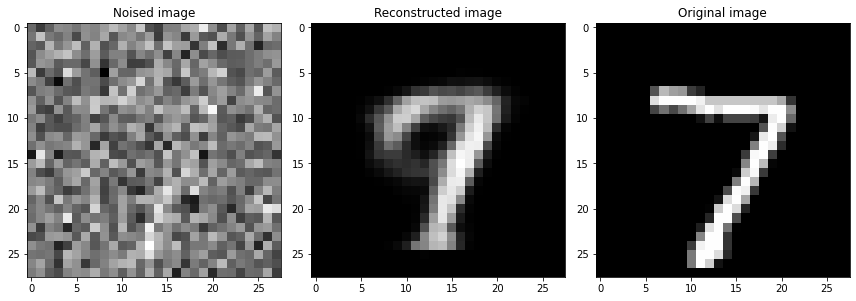

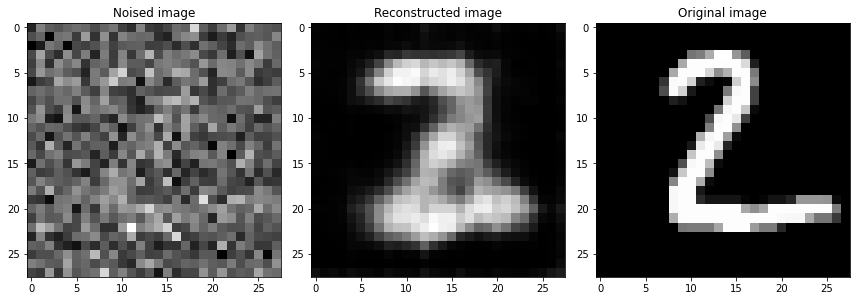

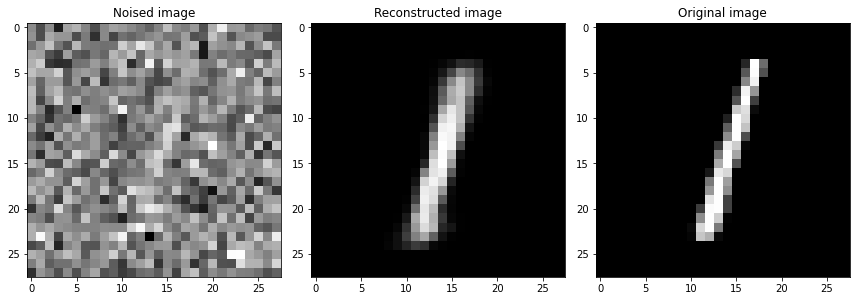

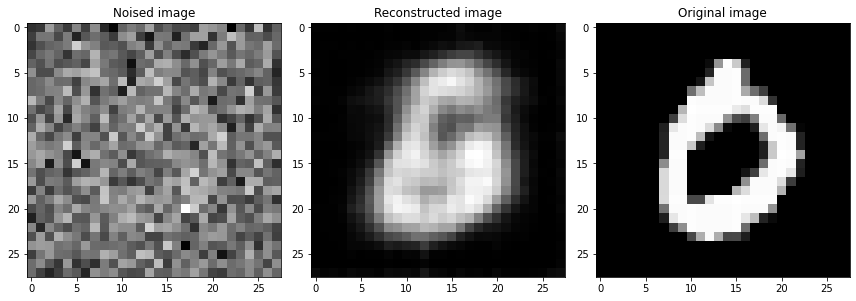

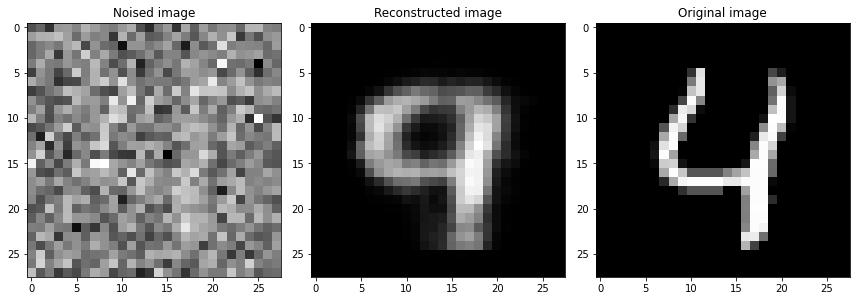

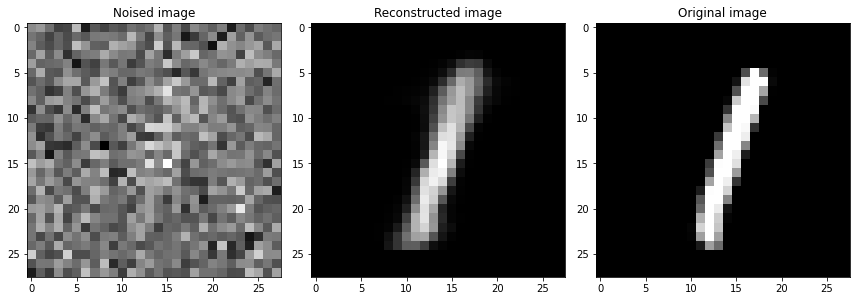

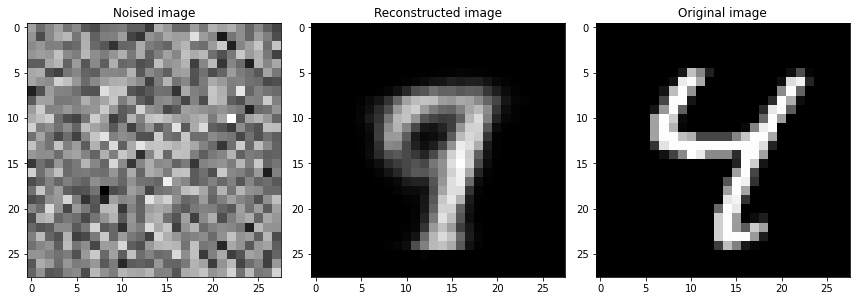

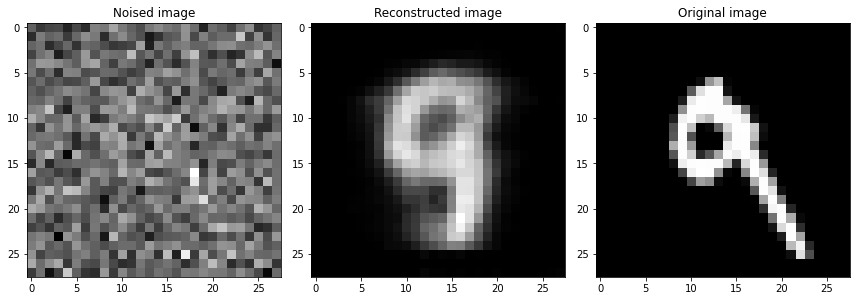

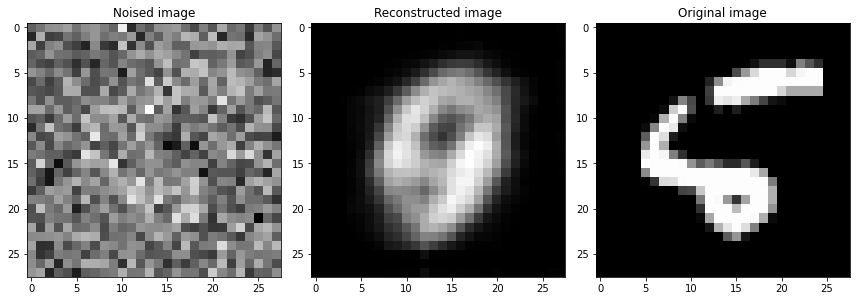

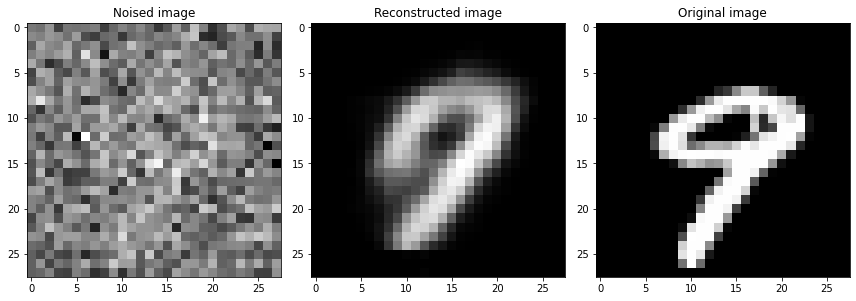

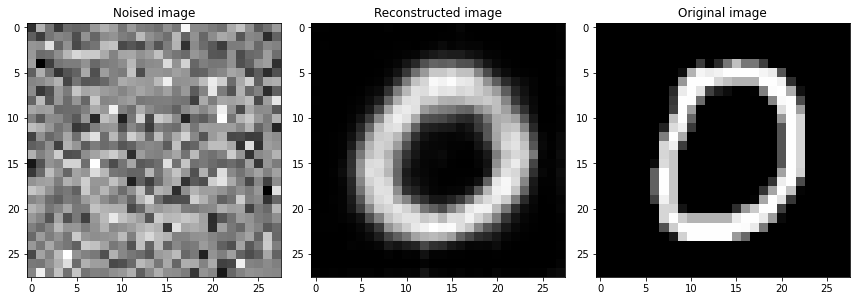

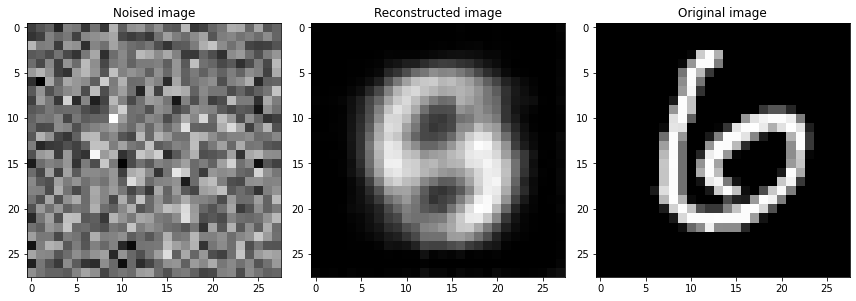

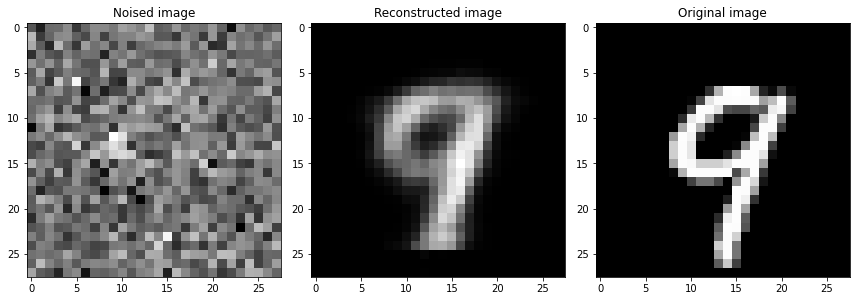

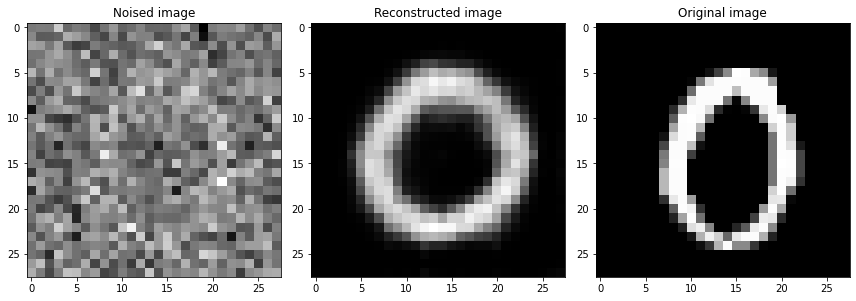

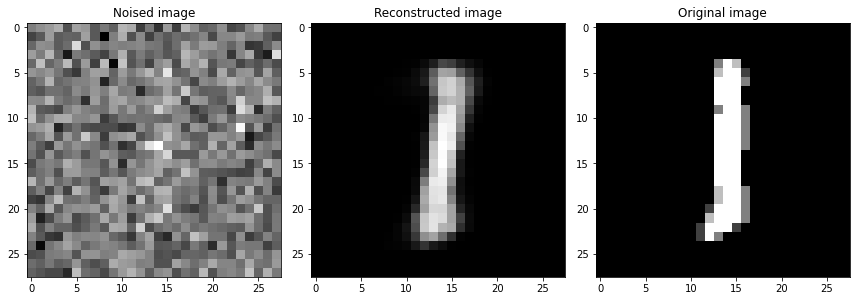

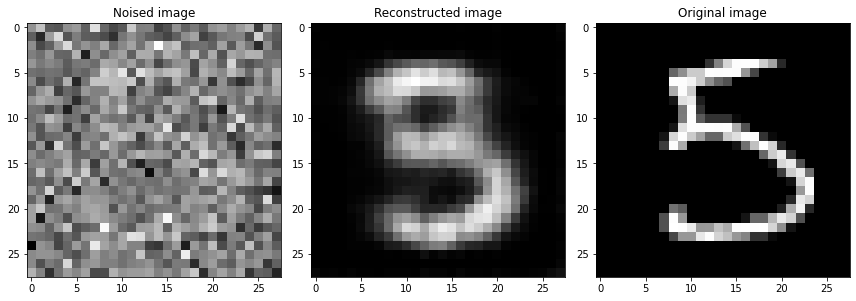

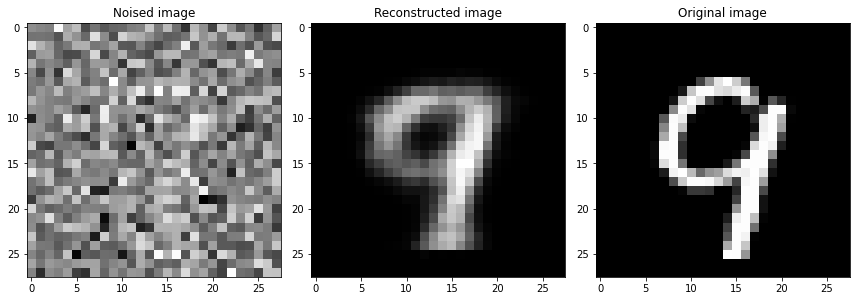

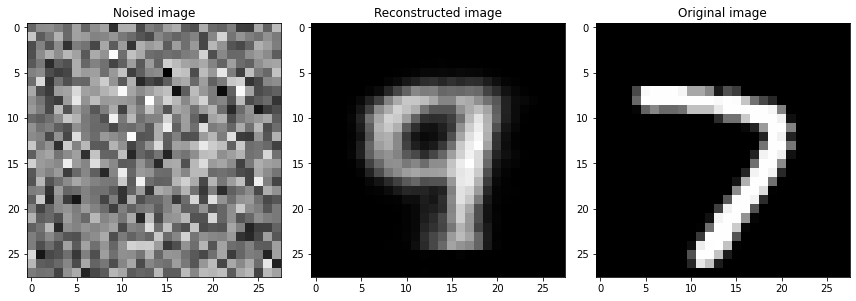

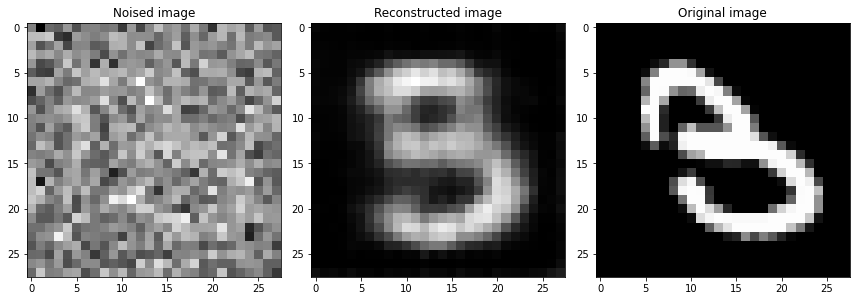

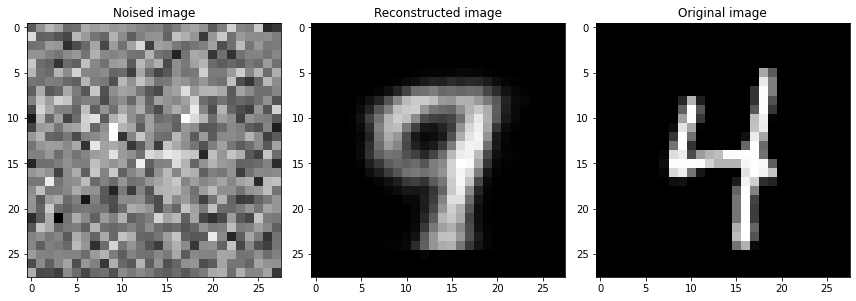

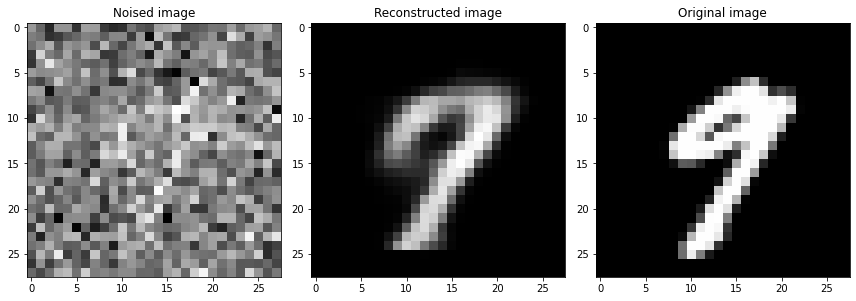

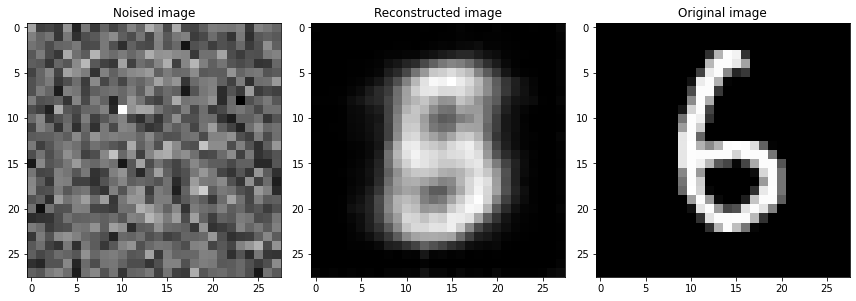

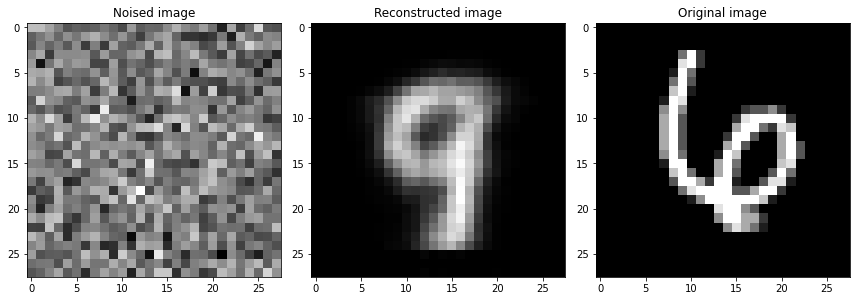

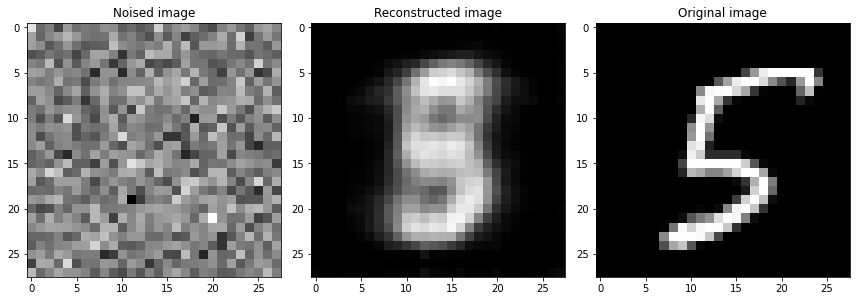

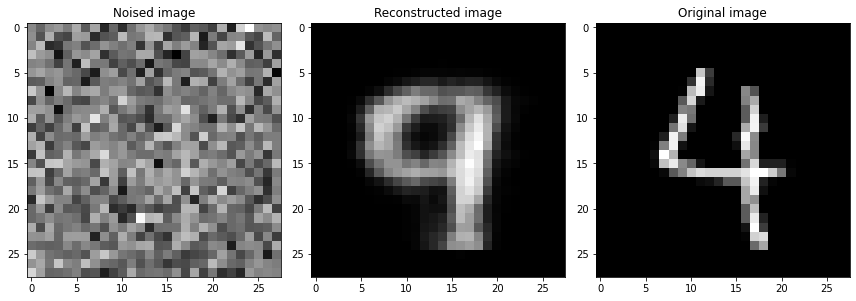

In [ ]:
with torch.no_grad():
  for image_batch in test_dataloader:
    for i in range(25):
      noised = image_batch[0].to(device)
      encoded = denoise_encoder(noised)
      denoised = denoise_decoder(encoded)
      denoised = denoised[i][0]
      original = image_batch[1][i][0]
      noised = noised[i]

      fig, axs = plt.subplots(1, 3, figsize=(12,6))
      axs[0].imshow(noised.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Noised image')
      axs[1].imshow(denoised.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image')
      axs[2].imshow(original.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[2].set_title('Original image')
      plt.tight_layout()
      plt.pause(0.1)
    break

# Supervised Task

In [ ]:
outputLayer = nn.Linear(encoded_space_dim, 10)
outputLayer = outputLayer.to(device)

In [ ]:
composed_transform = None#transforms.Compose([AddGaussianNoise(0., 1.)])

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': outputLayer.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

In [ ]:
num_epochs = 40
train_accuracy_log = []
val_accuracy_log = []
sig = nn.Sigmoid()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    train_pred = []
    val_pred = []
    for image_batch in train_dataloader:
      image = image_batch[0].to(device)
      label = image_batch[1].to(device)

      encoded = encoder(image)
      output = outputLayer(encoded)

      loss = loss_fn(output, label)
      outputLayer.zero_grad()
      loss.backward()
      optim.step()

      prediction = torch.argmax(sig(output), dim=1)
      
      accuracy = np.trace(confusion_matrix(prediction.cpu(), label.cpu())) / 100#(prediction == label).int().sum().item() / image.shape[0]
      train_pred.append(accuracy)

    with torch.no_grad():
      for image_batch in val_dataloader:
        image = image_batch[0].to(device)
        label = image_batch[1].to(device)

        encoded = encoder(image)
        output = outputLayer(encoded)

        prediction = torch.argmax(sig(output), dim=1)
        accuracy = (prediction == label).int().sum().item() / image.shape[0]
        val_pred.append(accuracy)

    
    train_pred = np.mean(train_pred)
    print(f"AVERAGE TRAIN ACCURACY: {train_pred * 100}%")
    train_accuracy_log.append(train_pred)

    val_pred = np.mean(val_pred)
    print(f"AVERAGE VALIDATION ACCURACY: {val_pred * 100}%")
    val_accuracy_log.append(val_pred)

    
    
    

EPOCH 1/40
AVERAGE TRAIN ACCURACY: 74.43124999999999%
AVERAGE VALIDATION ACCURACY: 76.45833333333333%
EPOCH 2/40
AVERAGE TRAIN ACCURACY: 74.46458333333334%
AVERAGE VALIDATION ACCURACY: 76.55833333333332%
EPOCH 3/40
AVERAGE TRAIN ACCURACY: 74.51666666666667%
AVERAGE VALIDATION ACCURACY: 76.20833333333333%
EPOCH 4/40
AVERAGE TRAIN ACCURACY: 74.47291666666668%
AVERAGE VALIDATION ACCURACY: 76.0%
EPOCH 5/40
AVERAGE TRAIN ACCURACY: 74.44375%
AVERAGE VALIDATION ACCURACY: 76.28333333333333%
EPOCH 6/40
AVERAGE TRAIN ACCURACY: 74.47083333333333%
AVERAGE VALIDATION ACCURACY: 75.8%
EPOCH 7/40
AVERAGE TRAIN ACCURACY: 74.41875000000002%
AVERAGE VALIDATION ACCURACY: 75.89166666666667%
EPOCH 8/40
AVERAGE TRAIN ACCURACY: 74.40625%
AVERAGE VALIDATION ACCURACY: 76.30833333333334%
EPOCH 9/40
AVERAGE TRAIN ACCURACY: 74.48541666666667%
AVERAGE VALIDATION ACCURACY: 76.28333333333333%
EPOCH 10/40
AVERAGE TRAIN ACCURACY: 74.45%
AVERAGE VALIDATION ACCURACY: 75.98333333333333%
EPOCH 11/40
AVERAGE TRAIN ACCURACY:

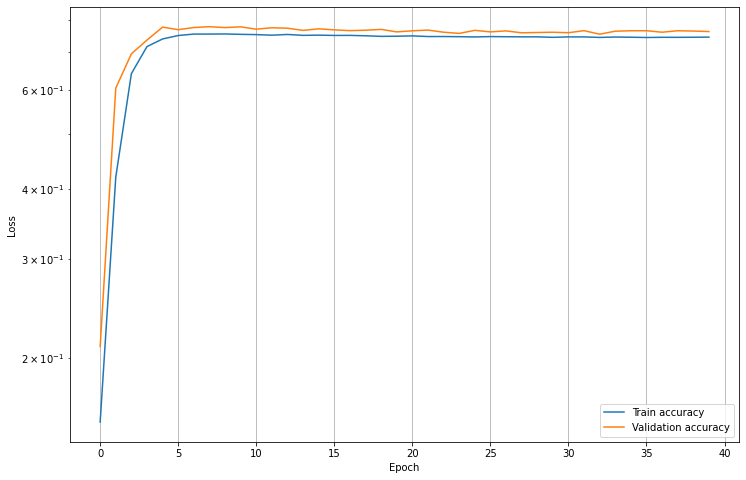

In [ ]:
plt.figure(figsize=(12,8))
plt.semilogy(train_accuracy_log, label='Train accuracy')
plt.semilogy(val_accuracy_log, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
accuracy_tot = []
with torch.no_grad():
  for batch_image in test_dataloader:
    images = batch_image[0].to(device)
    labels = batch_image[1].to(device)

    encoded = encoder(images)
    output = outputLayer(encoded)

    prediction = torch.argmax(sig(output), dim=1)

    accuracy = np.trace(confusion_matrix(prediction.cpu(), labels.cpu())) / 100
    accuracy_tot.append(accuracy)
  accuracy = np.mean(accuracy_tot)
  print(f"AVERAGE TEST ACCURACY: {accuracy}%")


AVERAGE TEST ACCURACY: 75.23%


In [ ]:
confusion_matrix(prediction.cpu(), labels.cpu())

array([[ 920,    0,   11,    1,   13,   24,  264,    0,    4,   11],
       [   0, 1064,   63,   23,    0,    2,    8,   86,    4,    8],
       [   0,    6,  839,   35,    0,    4,   68,   22,    2,    1],
       [   2,   27,   63,  791,    2,   89,    9,    6,  118,    6],
       [   0,    0,    0,    0,  615,   27,    1,   77,    4,  251],
       [  42,    1,   12,   12,   38,  573,   45,    1,   60,   12],
       [  12,    2,   11,    5,   11,   25,  561,    0,    0,    1],
       [   1,    0,    8,    7,    9,    0,    0,  773,    4,   69],
       [   3,   34,   24,  130,   27,  134,    2,   14,  763,   26],
       [   0,    1,    1,    6,  267,   14,    0,   49,   15,  624]])